In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [2]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from dataclasses import dataclass, fields, asdict
import itertools
from itertools import chain, product
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback
import pickle, gzip

# from multiprocessing import Pool
# from torch.multiprocessing import Pool
# torch.multiprocessing.set_start_method('spawn', force=True)
from multiprocessing.dummy import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

# from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer#, pipeline
# from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW
torch.set_grad_enabled(False);

In utils/hub.py: default_cache_path: /raid3/xd/.cache/torch/hub->/nas/xd/.cache/torch/transformers/


In [3]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence
from fn import _ as __

In [123]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
with Timer('utils'): from utils import *
with Timer('child_utils'): from child_utils_mqy import *
from child_utils import _str, _cxt2str, _item2str, _s, _be
from child_frames import *
with Timer('tasks'): from tasks import *
with Timer('model_utils'): from model_utils_mqy import *
with Timer('weight_analysis'): from weight_analysis import *

common_utils ... done 0:00:00.000090
utils ... done 0:00:00.000090
child_utils ... done 0:00:00.000369
tasks ... done 0:00:00.000087
model_utils ... done 0:00:00.000162
weight_analysis ... done 0:00:00.000060


In [5]:
import circuitsvis as cv
import plotly.express as px
from sklearn.manifold import TSNE
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [6]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-neox-20b on elderberry
proxies = {'http': '192.168.50.1:1081'} 

In [7]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['EleutherAI/gpt-j-6B/cpu',
                   'gpt2-medium/cpu',
                    #'EleutherAI/gpt-j-6B',
#                    'EleutherAI/gpt-neox-20b/cpu', #'EleutherAI/gpt-neox-20b'
                  ]#, 'gpt2-xl', 'gpt2']
#                    'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B']
for model_name in s2s_model_names[:0] + gpt_model_names[:2]:#, 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'KoboldAI/fairseq-dense-6.7B']:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        # _cache_dir = cache_dir.replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        kwargs = dict(cache_dir=cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if '/cpu' in model_name or 'gpt-j' not in model_name and 'gpt-neox' not in model_name:
            model = model_cls.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir, proxies=proxies)
        elif 'gpt-j' in model_name:
            device = 6
            model = model_cls.from_pretrained(model_name, revision="float16", torch_dtype=torch.float16, **kwargs).to(device)
        elif 'gpt-neox' in model_name:
            device = 8; device_map = {'gpt_neox': device, 'embed_out': device}
            model = model_cls.from_pretrained(model_name, device_map=device_map, load_in_8bit=True, **kwargs)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # if model_name in ['EleutherAI/gpt-neox-20b']: model = model.half()
        tokenizer = AutoTokenizer.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir)
        unify(model)
        models[model_name] = model, tokenizer

EleutherAI/gpt-j-6B/cpu ... done 0:06:49.494306
gpt2-medium/cpu ... done 0:00:33.449967


In [280]:
model_name = gpt_model_names[0]  # engines[4]
model, tokenizer = models[model_name]
model_name_gpu = model_name.replace('/cpu', '')
model_gpu = models[model_name_gpu][0] if model_name_gpu in models else model

In [281]:
blocks = model.transformer.h
for i, b in enumerate(blocks): b.layer = i
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), blocks[0].attn.num_heads, blocks[0].attn.embed_dim

# we = model.transformer.wte.weight.data
# wu = model.lm_head.weight.data

# es = [we]
# for b in blocks[:1]: es.append(es[-1] + mlp_forward(b, es[-1]))
# model.es = es
# weBTAs = [es[i].T @ es[i] for i in range(2)]
# model.weBTAs = weBTAs

In [13]:
# clone model 
device = torch.device('cuda:6')
# _ = clone_model_to(model, device)

In [200]:
# tasks = [
#     (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(genders_of_persons).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
#     ), 
#     (lambda: [TreeSet(types_of_things).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
#     ), 
#     (lambda: [TreeSet(countries_of_cities).use(['equal', 'child', 'sibling']), TreeSet(countries_of_cities).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
#     ),
#     (lambda: fork_vocab(TreeSet(capabilities_of_things), [['equal', 'child', 'sibling']] * 2), MlM_gen, None, None,
#     ), 
#     (lambda: fork_vocab(SymSet(person_adjs), [['equal'], ['opposite']]), MlM_gen, None, None,
#     ), 
#     (lambda: fork_vocab(PoSet(temporal_poset), [['equal'], ['prev']]), MlM_gen, None, None,
#     ), 
#     (lambda: fork_vocab(PoSet(temporal_poset), [['equal'], ['next']]), MlM_gen, None, None,
#     ), 
# #     (lambda: [TreeSet(types_of_characters).use('child'), TreeSet(types_of_things).use('child')], partial(MlM_gen, cxt_sample_fn=enumerate_sample, query=1),
# #      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {i[1]}", f"{the_(i[1])} is {i[0]}'s"]), lambda q, _: f"{q}", " likes"
# #     ),
#     (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['child', 'equal', 'sibling'])], MlM_gen,
# #      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}", f"{_be(the_(i[1]))} {i[0]}'s"]), lambda q, _: f"{the_(q)} likes",
#      partial(_cxt2str, prefix="< ", suffix=" >.", item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}.", f"{_be(the_(i[1]))} {i[0]}'s."]), lambda q, _: f"What {the_(q)} has is",
#     ), # t: 21-5, 15-8, 19. p: 16-7, 18-5, [3-12, 13-7]. p+: 16-7, 16-0. 13-7:induction head qk, thing->type ov
#     (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(countries_of_cities).use(['child', 'equal', 'sibling'])], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} likes {i[1]}.", f"{i[1]} attracts {the_(i[0], uppercase=False)}."]), lambda q, _: f'{the_(q)} wanna go to',
#     ), # t: 19-12 >> 16-10 = 12-7
#     (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(capabilities_of_things).use(['child'])], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}.", f"{_be(the_(i[1]))} {i[0]}'s."]), lambda q, _: f'{the_(q)} has'
#     ),
# #     (lambda: [TreeSet(genders_of_persons).use('equal'), SymSet(person_adjs).use('equal')], MlM_gen,
# #      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} is {i[1]}", f"{i[1].capitalize()} is {i[0]}"]), lambda q, _: f"Yes, {q} looks", " like"
# #     ),
#     (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), SymSet(person_adjs).use(['opposite'])], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} is {i[1]}.", f"{capitalize(i[1])} {i[0]}."]), lambda q, _: f"{the_(q)} is",
#     ), # t: 16-14, somewhat 14-7 # verbose acc: gpj-j > curie-001 > davinci-001 > gpt-neox!? abstract acc: gpt-neox > gpt-j. all poor (inc. davinci-002!)
# #     (lambda: [TreeSet(genders_of_persons).use('equal'), PoSet(temporal_posets).use('equal')], MlM_gen,
# #      partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {wrap_noun2(i[1])}', f'{wrap_noun2(i[1]).capitalize()} arrived {i[0]}']), lambda q, _: f"So {q}'s arrival time", ' is'
# #     ),
#     (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), PoSet(temporal_poset).use(['prev'])], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {prep_(i[1])}.', f'{capitalize(prep_(i[1]))} arrived {i[0]}.']), lambda q, _: f'{the_(q)} arrived'
#     ),
#     (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), PoSet(temporal_poset).use(['next'])], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {prep_(i[1])}.', f'{capitalize(prep_(i[1]))} arrived {i[0]}.']), lambda q, _: f'{the_(q)} arrived'
#     ),
# ]

# tasks = [
#     # same person copy thing
#     (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['child', 'equal', 'sibling'])], MlM_gen,
# # partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}", f"{_be(the_(i[1]))} {i[0]}'s"]), lambda q, _: f"{the_(q)} likes",
#  partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}", f"{_be(the_(i[1]))} {i[0]}'s"]), lambda q, _: f"What {the_(q)} has is",
# ), 
#     # thing -> kind (TODO)
#     (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['child', 'equal', 'sibling'])], MlM_gen,
#  partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} likes {i[1]}", f"{i[1]} attracts {the_(i[0], uppercase=False)}"]), lambda q, _: f'{the_(q)} wanna go to',
# ),
#     #country -> capital
#     (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(countries_of_cities).use(['child', 'equal', 'sibling'])], MlM_gen,
#  partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} likes {i[1]}", f"{i[1]} attracts {the_(i[0], uppercase=False)}"]), lambda q, _: f'{the_(q)} wanna go to',
# ),
#     # opposite
#     (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), SymSet(person_adjs).use(['opposite'])], MlM_gen,
#  partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} is {i[1]}", f"{capitalize(i[1])} {i[0]}"]), lambda q, _: f"{the_(q)} is",
# ), 
#     # find special
#     (lambda: [TreeSet(types_of_things).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,), 
# ]

from child_utils import empty_cxt2str

tasks = [
    (lambda: [TreeSet(country2capital).use(['equal']), TreeSet(country2capital).use(['child'])], MlM_gen,
    empty_cxt2str, lambda q, _: f"{q} is",
    ), 
    (lambda: [TreeSet(do2did).use(['equal']), TreeSet(do2did).use(['child'])], MlM_gen,
     empty_cxt2str, lambda q, _: f"{q} is",
    ), 
    (lambda: [TreeSet(pasttenses_of_verbs).use(['equal']), TreeSet(pasttenses_of_verbs).use(['child'])], MlM_gen,
     empty_cxt2str, lambda q, _: f"Today I {q}. Yesterday I",
    ), 
    (lambda: [TreeSet(word2capitalized).use(['equal']), TreeSet(word2capitalized).use(['child'])], MlM_gen,
     empty_cxt2str, lambda q, _: f"{q} is",
    ), 
    (lambda: [TreeSet(letter2uppercase).use(['equal']), TreeSet(letter2uppercase).use(['child'])], MlM_gen,
     empty_cxt2str, lambda q, _: f"{q} is",
    ), 
    
    
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(genders_of_persons).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
    ), 
    (lambda: [TreeSet(types_of_things).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
    ), 
    (lambda: [TreeSet(countries_of_cities).use(['equal', 'child', 'sibling']), TreeSet(countries_of_cities).use(['equal', 'child', 'sibling'])], MlM_gen, None, None,
    ),
    (lambda: fork_vocab(TreeSet(capabilities_of_things), [['equal', 'child', 'sibling']] * 2), MlM_gen, None, None,
    ), 
    (lambda: fork_vocab(SymSet(person_adjs), [['equal'], ['opposite']]), MlM_gen, None, None,
    ), 
    (lambda: fork_vocab(PoSet(temporal_poset), [['equal'], ['prev']]), MlM_gen, None, None,
    ), 
    (lambda: fork_vocab(PoSet(temporal_poset), [['equal'], ['next']]), MlM_gen, None, None,
    ), 
#     (lambda: [TreeSet(types_of_things).use(['equal']), TreeSet(types_of_things).use(['equal', 'child'])], partial(MlM_gen, cxt_sample_fn=enumerate_sample, query=1),
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {i[1]}", f"{the_(i[1])} is {i[0]}'s"]), lambda q, _: f"{q}", " likes"
#     ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(types_of_things).use(['child', 'equal', 'sibling'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}.", f"{_be(the_(i[1]))} {i[0]}'s."]), lambda q, _: f"{the_(q)} has",
    ), # t: 21-5, 15-8, 19. p: 16-7, 18-5, [3-12, 13-7]. p+: 16-7, 16-0. 13-7:induction head qk, thing->type ov
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(countries_of_cities).use(['child', 'equal', 'sibling'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} likes {i[1]}.", f"{i[1]} attracts {the_(i[0], uppercase=False)}."]), lambda q, _: f'{the_(q)} wants to go to',
    ), # t: 19-12 >> 16-10 = 12-7
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), TreeSet(capabilities_of_things).use(['child'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} has {a_(i[1])}.", f"{_be(the_(i[1]))} {i[0]}'s."]), lambda q, _: f"{the_(q)} has"
    ),
#     (lambda: [TreeSet(genders_of_persons).use('equal'), SymSet(person_adjs).use('equal')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f"{i[0]} is {i[1]}", f"{i[1].capitalize()} is {i[0]}"]), lambda q, _: f"Yes, {q} looks", " like"
#     ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), SymSet(person_adjs).use(['opposite'])], MlM_gen,
     partial(_cxt2str,item2str=lambda i, _: [f"{i[0]} is {i[1]}.", f"{capitalize(i[1])} {i[0]}."]), lambda q, _: f"{the_(q)} is",
    ), # t: 16-14, somewhat 14-7 # verbose acc: gpj-j > curie-001 > davinci-001 > gpt-neox!? abstract acc: gpt-neox > gpt-j. all poor (inc. davinci-002!)
#     (lambda: [TreeSet(genders_of_persons).use('equal'), PoSet(temporal_posets).use('equal')], MlM_gen,
#      partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {wrap_noun2(i[1])}', f'{wrap_noun2(i[1]).capitalize()} arrived {i[0]}']), lambda q, _: f"So {q}'s arrival time", ' is'
#     ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), PoSet(temporal_poset).use(['prev'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {prep_(i[1])}.', f'{capitalize(prep_(i[1]))} arrived {i[0]}.']), lambda q, _: f'{the_(q)} arrived'
    ),
    (lambda: [TreeSet(genders_of_persons).use(['equal', 'child', 'sibling']), PoSet(temporal_poset).use(['next'])], MlM_gen,
     partial(_cxt2str, item2str=lambda i, _: [f'{i[0]} arrived {prep_(i[1])}.', f'{capitalize(prep_(i[1]))} arrived {i[0]}.']), lambda q, _: f'{the_(q)} arrived'
    ),
]

In const.py: Loading tokenizer ... done 0:00:00.331468


In [282]:
results = {}; key = None

In [432]:
nrows, k_shot = 2, 1; cxt_len = 1; save_results = False
batch_size = 1; verbose = False #not save_results or batch_size <= 8
rel1_kwargs = {'x_f': None}  # {'x_f': _s, 'y_f': a_, 'skip_inv_f':False}
for task,        rel0_i, rel1_i, do_swap_qa, do_negate, do_rm_query, rev_item2str, do_g2c in product(
    tasks[3:4], [0],[0],[False, True],  [False],[False],[False],[False]):
    seed(42)
    args = dict(cxt_len=cxt_len, rev_item2str=rev_item2str, abstract=False)
    trans_args = dict(rel0_i=rel0_i, rel1_i=rel1_i, rel1_kwargs=rel1_kwargs, do_swap_qa=do_swap_qa, do_negate=do_negate,
                      do_rm_query=do_rm_query, do_g2c=do_g2c)
    task = transform_and_validate_task(task, **trans_args, **args)
    if task is None: continue
    res_key = f'{task2str(task)}[{args2str(args)}]'
    print(f'\n== {res_key} == {args2str(trans_args)}')
#     if key is not None and res_key != key: continue
    r = results[res_key] if save_results and res_key in results else None
#     if r is not None: print('duplicate task!'); continue 
    r = generate_and_predict_batch(model if save_results else model_gpu, tokenizer, task, nrows, k_shot, batch_size,
            custom_forward=save_results, result=r, verbose=verbose, **args)
    if save_results: results[res_key] = r
    if not save_results or getattr(r, 'mean_acc', 0) < 0.45: continue

    if True or r.root is None: r.root = add_node(None, layer=L, label_type='labels')
    r.root = attribute_tree_on(r.data_tuples, model, r.root, 1, topk=10, k_shot=k_shot, mix=True, device=device, verbose=True)


== MlM_gen[word2capitalized.TreeSet.equal,word2capitalized.TreeSet.child][cxt_len=1] == 
Taxi is the capitalized form of taxi
Laptop is the capitalized form of laptop

== MlM_gen[word2capitalized.TreeSet.child,word2capitalized.TreeSet.equal][cxt_len=1] == do_swap_qa
Which is the capitalized form of taxi? Taxi
Which is the capitalized form of laptop? Laptop


In [240]:
r.data_tuples[0][3] # ranges
r.data_tuples[0][0] #text

[Ranges(bos=(7, 8), ans=(8, 9), ans0=None, query=(6, 7), tgt=None, rel=(4, 5), sep=None, ans0s=None, example=(1, 9)),
 Ranges(bos=(16, 17), ans=(17, 18), ans0=None, query=(15, 16), tgt=None, rel=(13, 14), sep=None, ans0s=None, example=(10, 18))]

'\nWhich is the capital of Switzerland? Bern\nWhich is the capital of Greece? Athens\n'

In [284]:
print(f'\n== {res_key} == {args2str(trans_args)}')
print_tree(r.root)


== MlM_gen[country2capital.TreeSet.child,country2capital.TreeSet.equal][cxt_len=1] == do_swap_qa
 ┌@[0,1,4,5,7,8] 16-0,19-12,16-10,12-7,17-3,12-11 29 B->Q 45
 ├@[2,3,6] 17-m,19-m,18-m B->B 36
 ├@[9] 13-13 21 B->A]^ 8
 ├@0 16-0 100 B->Q 87/88/69/nan attn/example
 ├@0 16-0 100 B->Q 87/88/69/nan attn:B->~<s>
 ├@0 16-0 100 B->Q 87/88/69/nan
 ├@1 19-12 76 B->Q 44/25/-70/nan attn/example
 ├@1 19-12 76 B->Q 44/25/-70/nan attn:B->~<s>
 ├@1 19-12 76 B->Q 44/25/-70/nan
 ├@4 16-10 45 B->Q 63/29/2/nan attn/example
 ├@4 16-10 45 B->Q 63/29/2/nan attn:B->~<s>
 ├@4 16-10 45 B->Q 63/29/2/nan
 ├@5 12-7 42 B->Q 85/44/85/nan attn/example
 ├@5 12-7 42 B->Q 85/44/85/nan attn:B->~<s>
 ├@5 12-7 42 B->Q 85/44/85/nan
 ├@7 17-3 32 B->Q 83/54/79/nan attn/example
 ├@7 17-3 32 B->Q 83/54/79/nan attn:B->~<s>
 ├@7 17-3 32 B->Q 83/54/79/nan
 ├@2 17-m 74
 ├@3 19-m 63
 ├@6 18-m 38
 ┤
 │                                ┌@[1,2,4] 0-m,8-m,10-m B->B 51
 │                                ├@[3] 13-2 B->Q 14
 │                

In [232]:
node = r.root.children[-1]

In [200]:
node.data.attr is None

False

In [201]:
node_key = node2key(node); node_key

'17-9,18-2'

In [205]:
[node_key in dt[-1].attn_attr.keys() for dt in r.data_tuples]

[False, False, False, False, False, False, False, False]

In [161]:
for c in r.root.children:
    print(c.data.step, node2key(c),'-->',  c.data.label_type, '-->', c.data.attn_pattern) 
#         print(c.data.step, node2key(c),'-->', node2key(node2path(c)[0]), c.data.label_type) 

0 21-13,19-15,16-7,17-1,19-6,16-12,20-6,19-13 B->A0 70 --> None --> bos->ans0
0 25-m,24-10 B->B 14 --> None --> bos->bos
0 21-13 attn/ans0s --> attn_labels/ans0s --> bos->ans0
0 21-13 attn attr_k --> attn_labels --> bos->ans0
0 19-15 attn/ans0s --> attn_labels/ans0s --> bos->ans0
0 19-15 attn attr_k --> attn_labels --> bos->ans0
0 16-7 attn/ans0s --> attn_labels/ans0s --> bos->ans0
0 16-7 attn:B->~<s> --> attn_labels:bos->~<s>,3 --> bos->ans0
0 16-7 attn attr_k --> attn_labels --> bos->ans0
0 17-1 attn/ans0s --> attn_labels/ans0s --> bos->ans0
0 17-1 attn attr_k --> attn_labels --> bos->ans0
0 19-6 attn/ans0s --> attn_labels/ans0s --> bos->ans0
0 19-6 attn attr_k --> attn_labels --> bos->ans0
0 16-12 attn/ans0s --> attn_labels/ans0s --> bos->ans0
0 16-12 attn:B->~<s> --> attn_labels:bos->~<s>,3 --> bos->ans0
0 16-12 attn attr_k --> attn_labels --> bos->ans0
0 20-6 attn/ans0s --> attn_labels/ans0s --> bos->ans0
0 20-6 attn attr_k --> attn_labels --> bos->ans0
0 19-13 attn/ans0s --> attn

In [215]:
ranges = r.data_tuples[0][3]

In [216]:
r.data_tuples[0][1].size()

torch.Size([1, 19])

In [220]:
al = attn_pattern2labels(ranges, 'A]->A]', (19, 19), k_shot=0)

''

15-14
scaled_logprobs = tensor([ -8.8249,  -5.1093,  -7.8036, -11.9809])
 ĠTaxi 0.371 {'Ġtaxi': 0.585, 'ĠTaxi': 0.371, 'Ġtaxis': 0.019, 'ĠCelt': 0.01} 	 Which is the capitalized form of taxi? Taxi 
 ĠL 0.0 {'ĠLopez': 0.798, 'Ġlaptop': 0.074, 'glers': 0.06, 'ĠLap': 0.024} 	 Which is the capitalized form of laptop? Laptop 
11.980892181396484 0.0


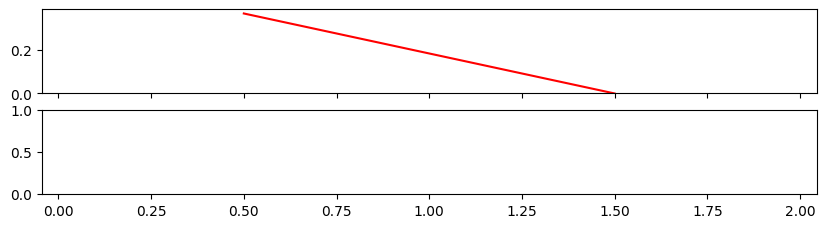

ap_scores = tensor([0.4809, 0.8035]) tensor(0.6422)


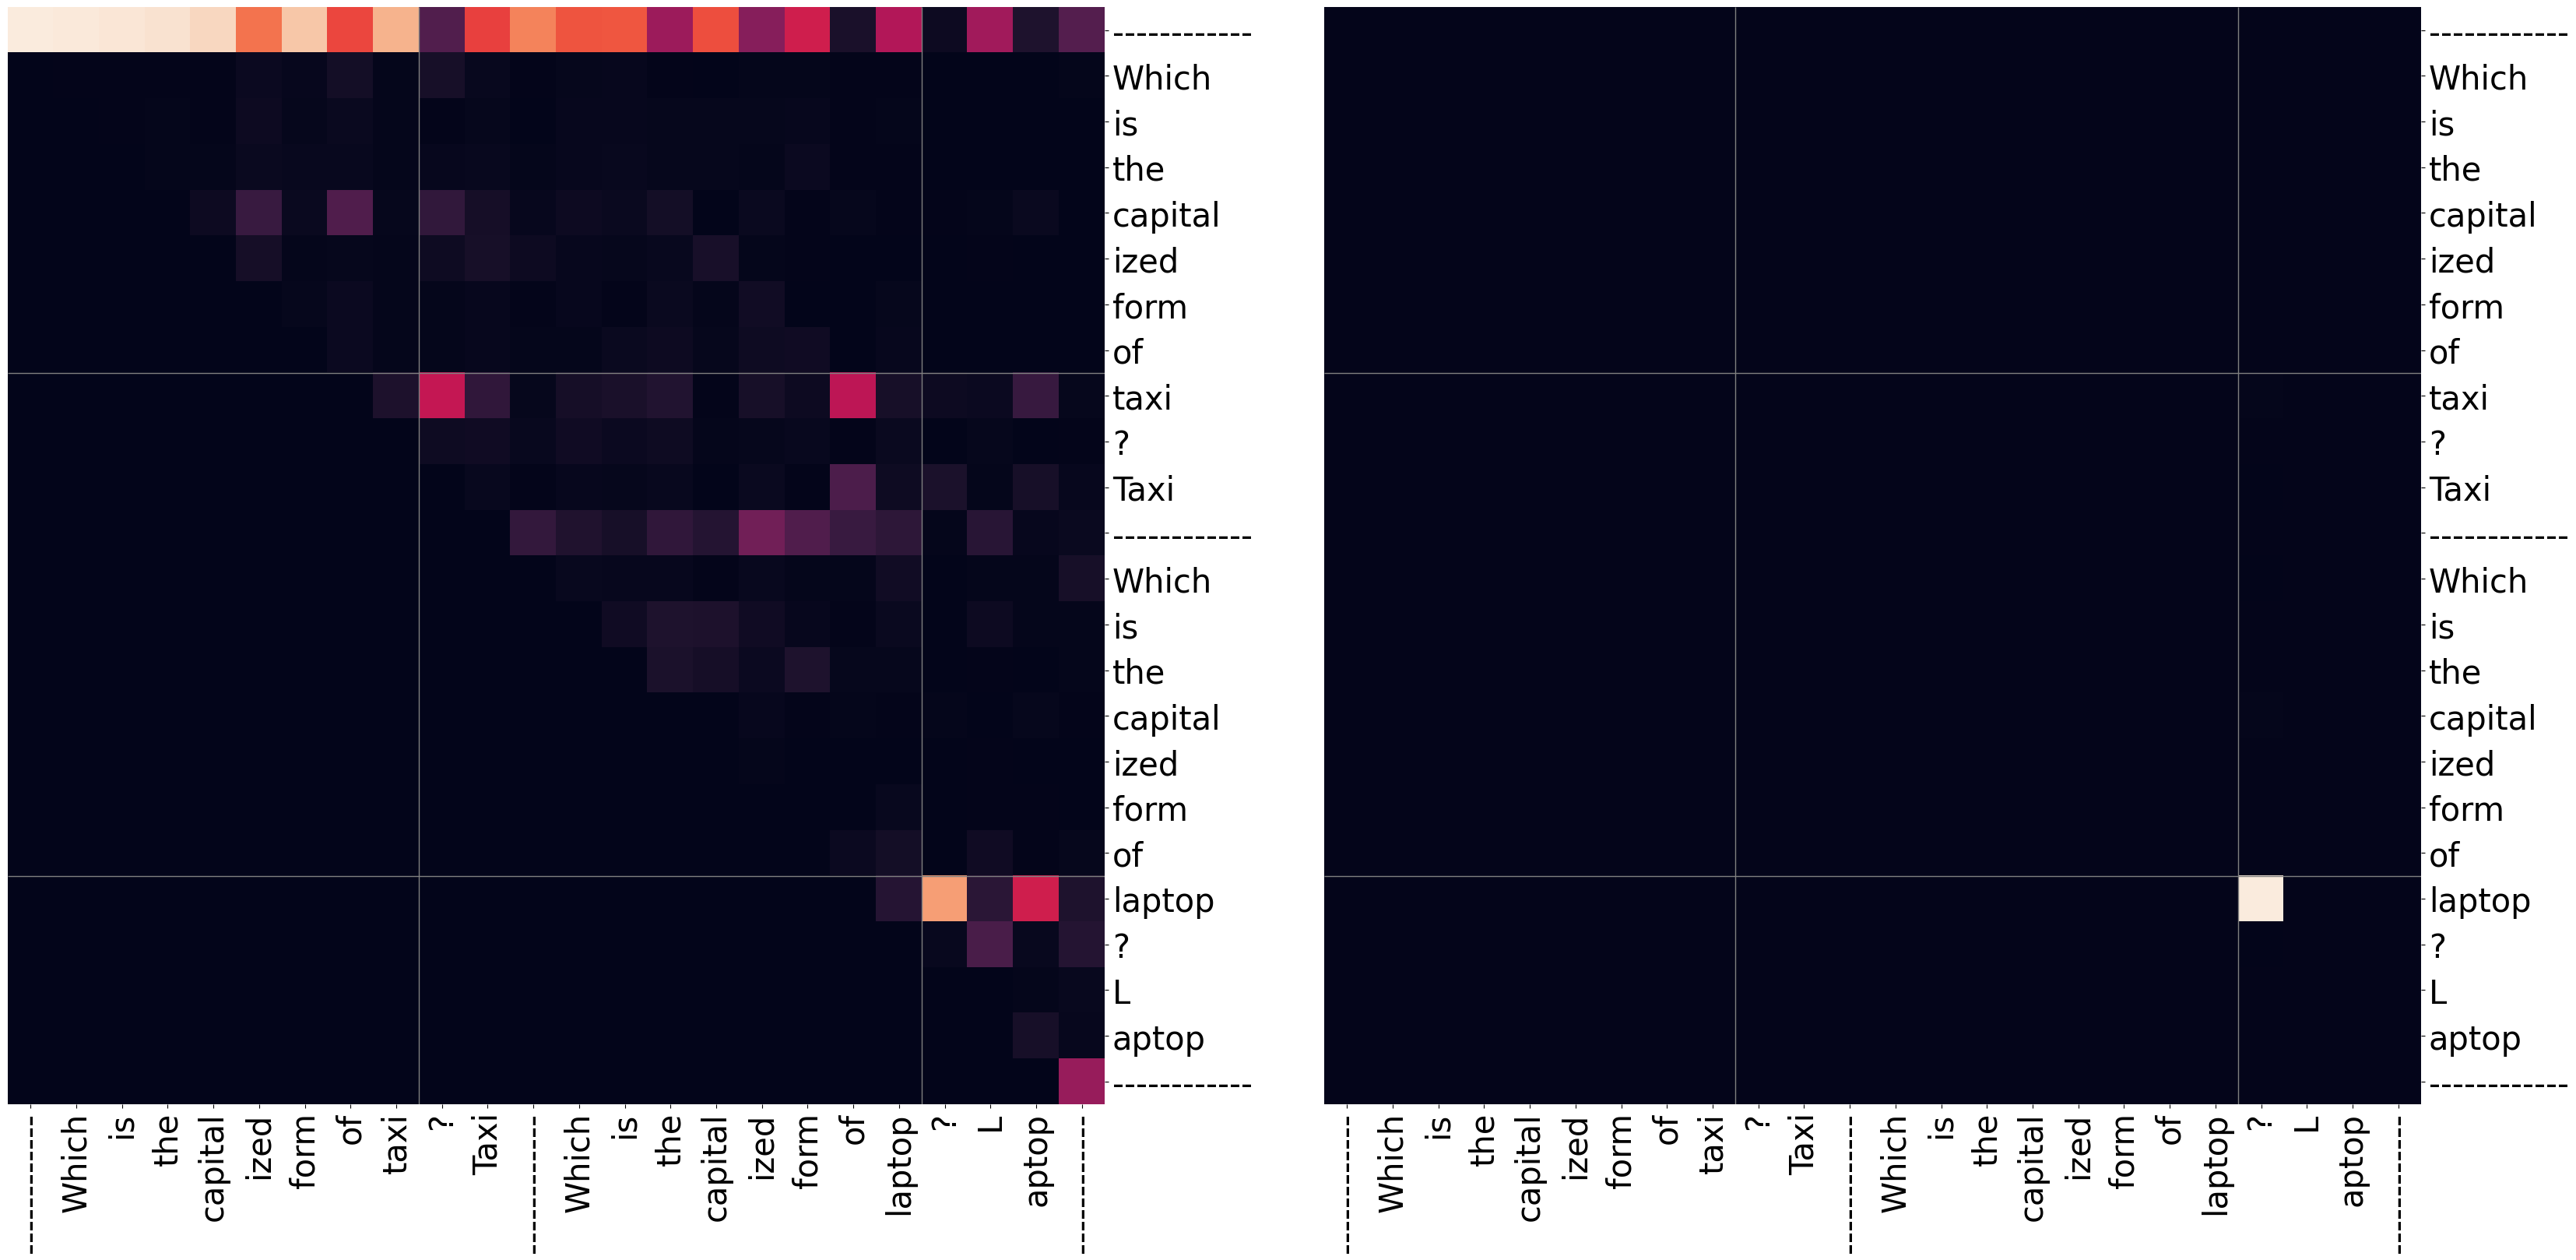

scaled_logprobs = tensor([-10.7345,  -1.1772,  -0.3970,  -0.2448])
 ĠCow 0.041 {'cow': 0.896, 'ĠCow': 0.041, 'Cow': 0.033, 'ĠCobra': 0.023} 	 Which is the capitalized form of cow? Cow 
*ĠPeach 0.783 {'ĠPeach': 0.783, 'Ġpeach': 0.217, 'PE': 0.0, 'ĠPon': 0.0} 	 Which is the capitalized form of peach? Peach 
0.24478627741336823 1.0


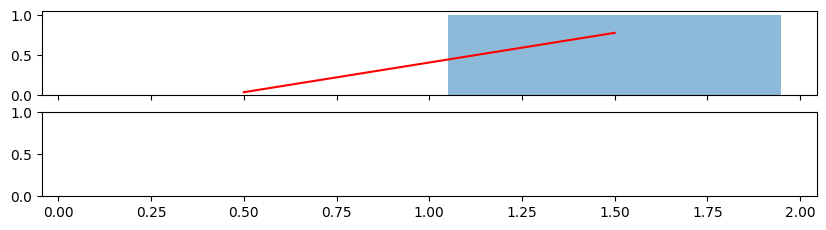

ap_scores = tensor([0.5196, 0.8310]) tensor(0.6753)


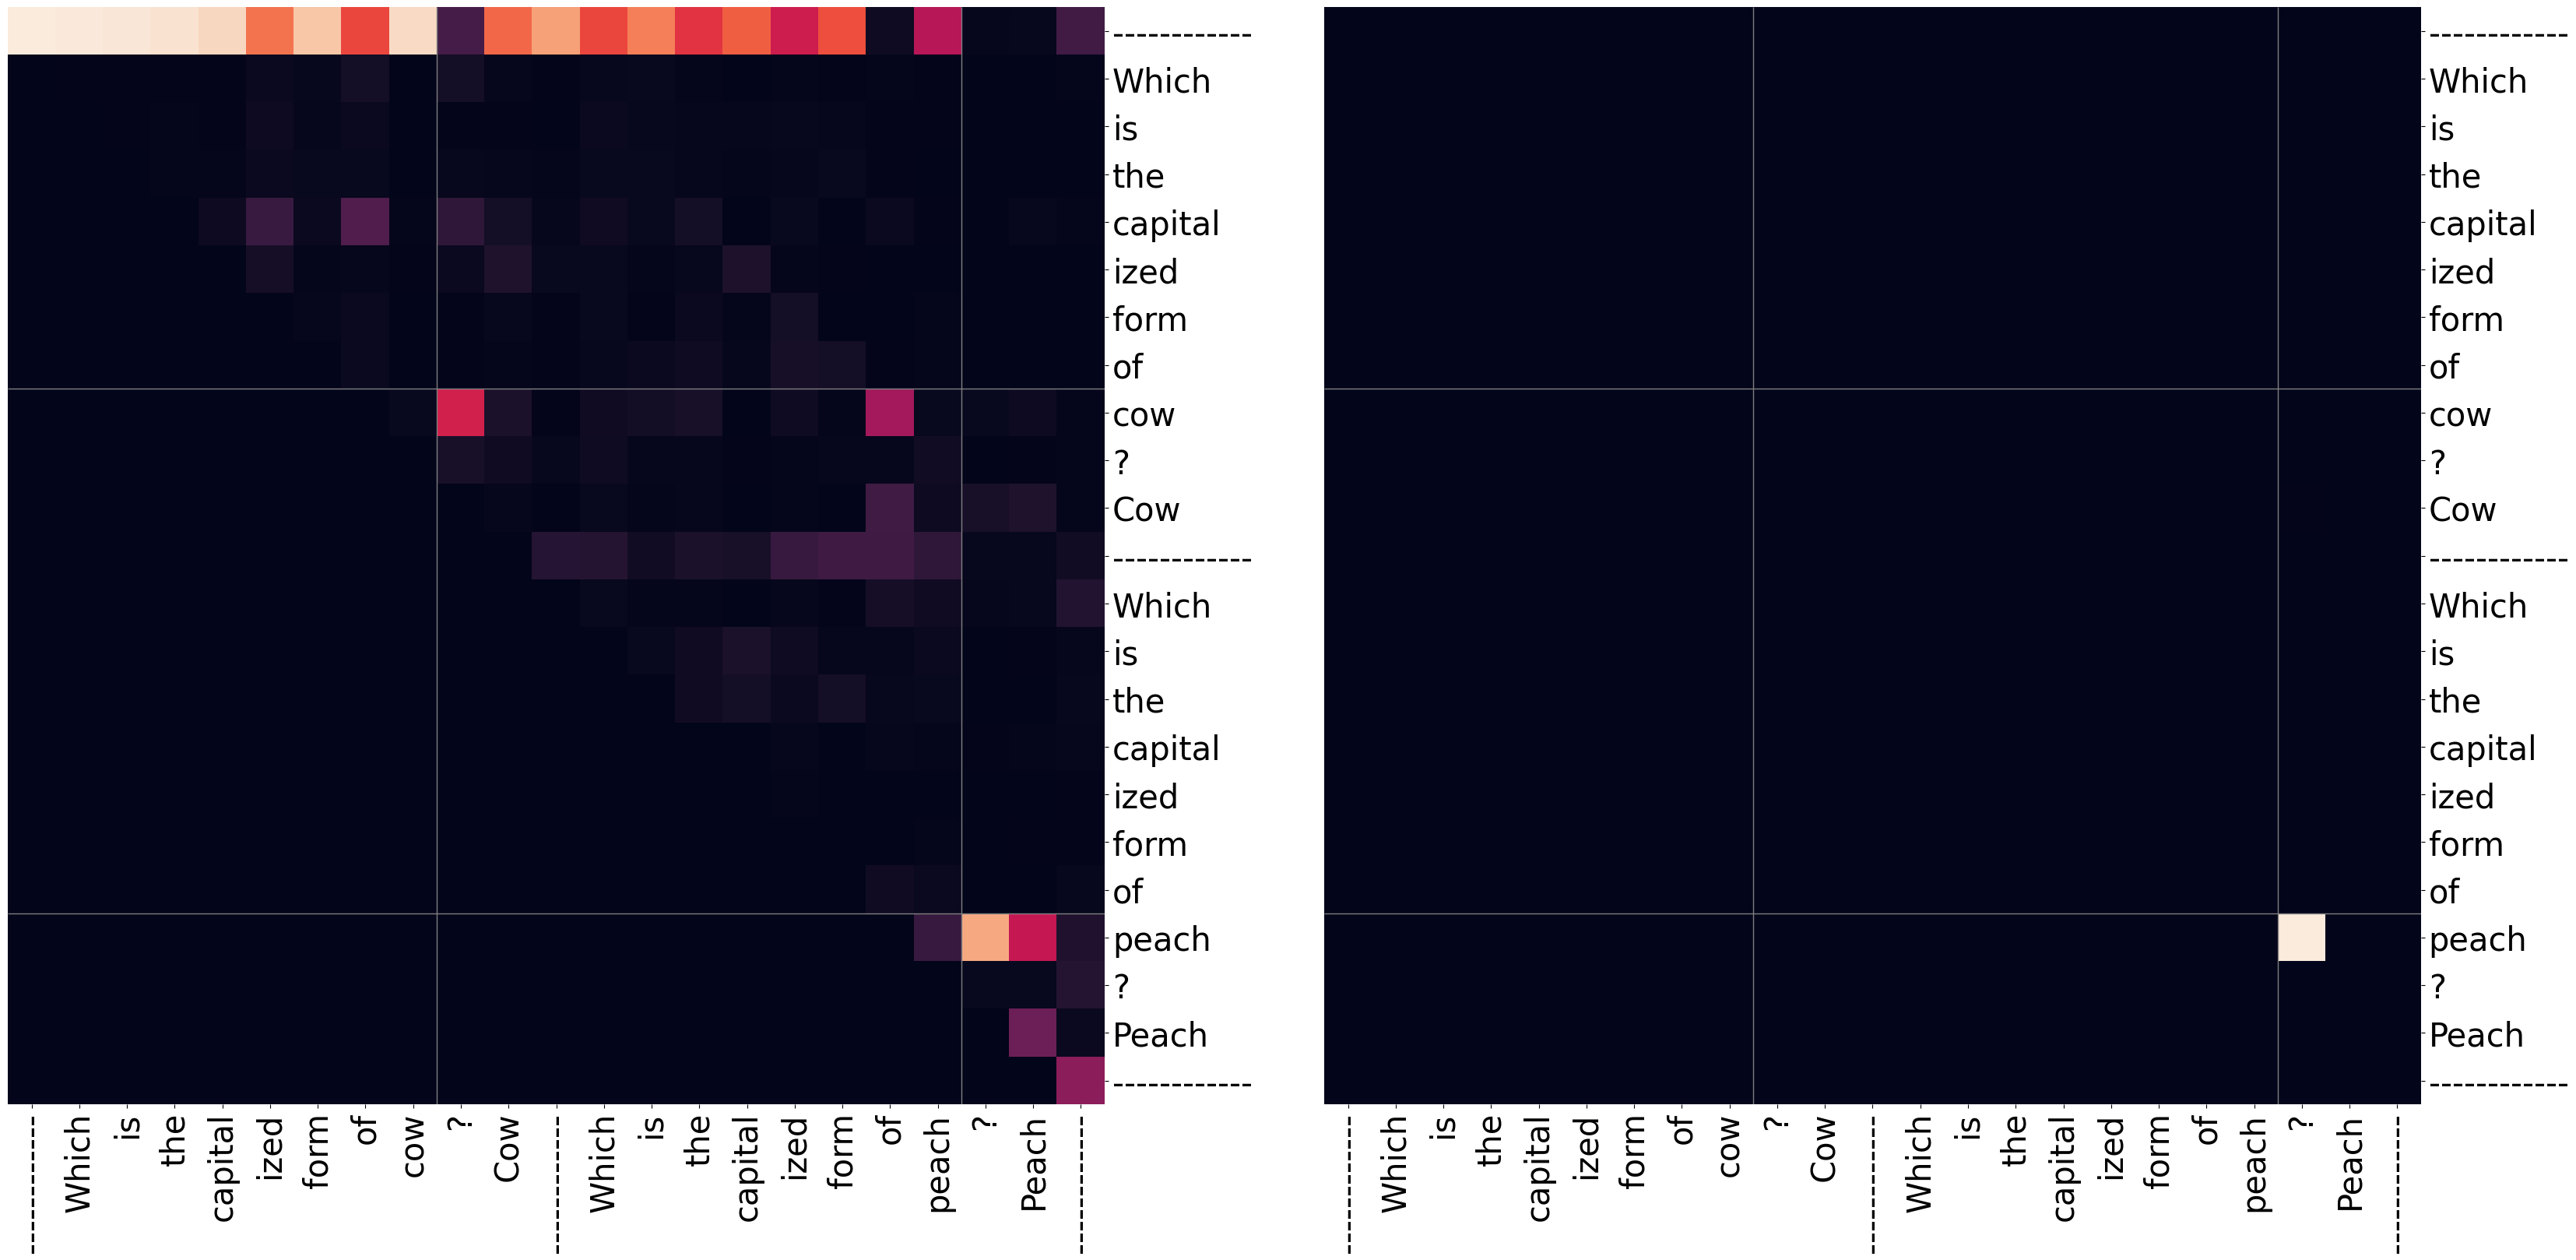

scaled_logprobs = tensor([-10.7792,  -4.7167,  -3.9513,  -4.9959])
 ĠPap 0.004 {'PK': 0.441, 'ĠPAL': 0.309, 'Pak': 0.054, 'Pa': 0.046} 	 Which is the capitalized form of papaya? Papaya 
 ĠSwe 0.007 {'ĠShelby': 0.663, 'Ġsweater': 0.181, 'Ġswe': 0.069, 'ĠScher': 0.022} 	 Which is the capitalized form of sweater? Sweater 
4.995916366577148 0.0


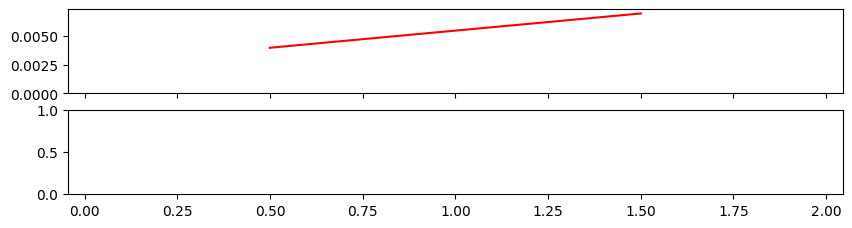

ap_scores = tensor([0.5407, 0.9077]) tensor(0.7242)


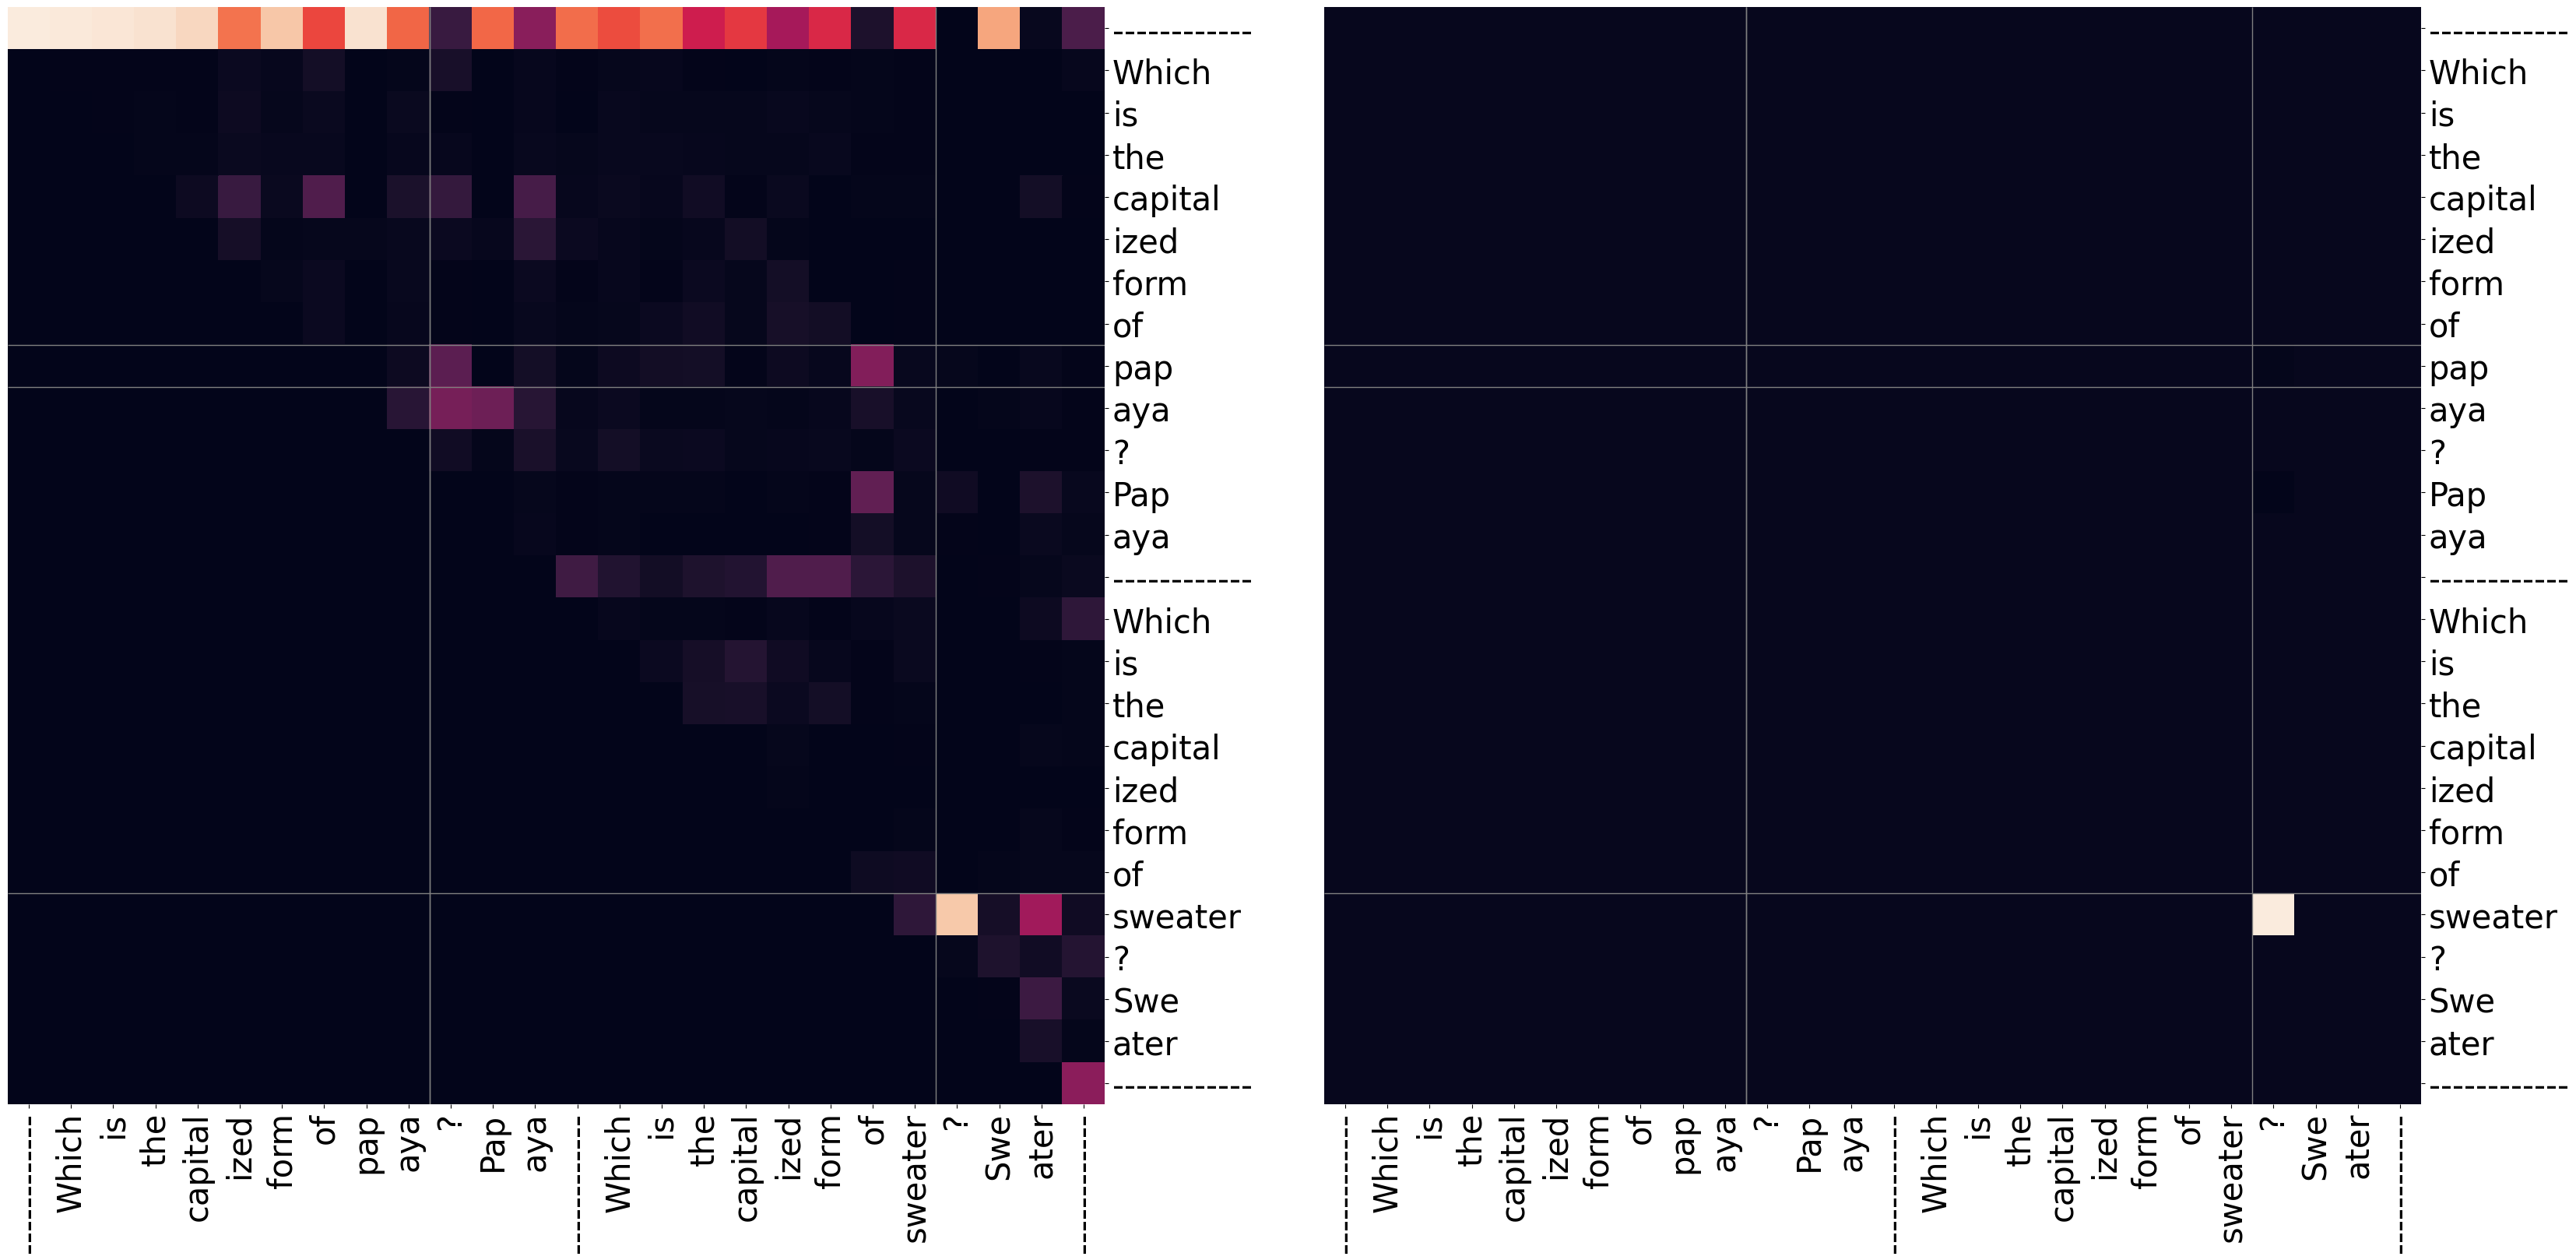

scaled_logprobs = tensor([-11.1527,  -2.2545,  -0.9286,  -0.7212])
 ĠJuice 0.033 {'ggy': 0.206, 'JV': 0.182, 'ju': 0.135, 'KI': 0.083} 	 Which is the capitalized form of juice? Juice 
*ĠWine 0.486 {'ĠWine': 0.486, 'wine': 0.261, 'Ġwine': 0.175, 'Ġwines': 0.066} 	 Which is the capitalized form of wine? Wine 
0.7212299108505249 1.0


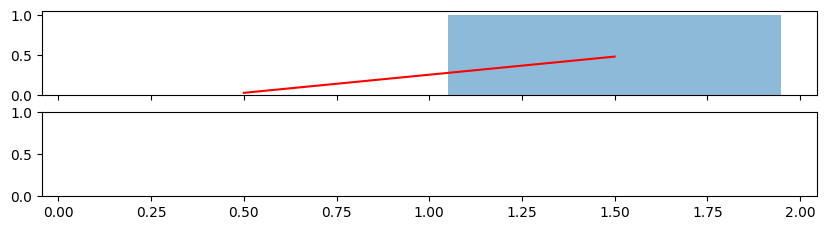

ap_scores = tensor([0.3305, 0.7689]) tensor(0.5497)


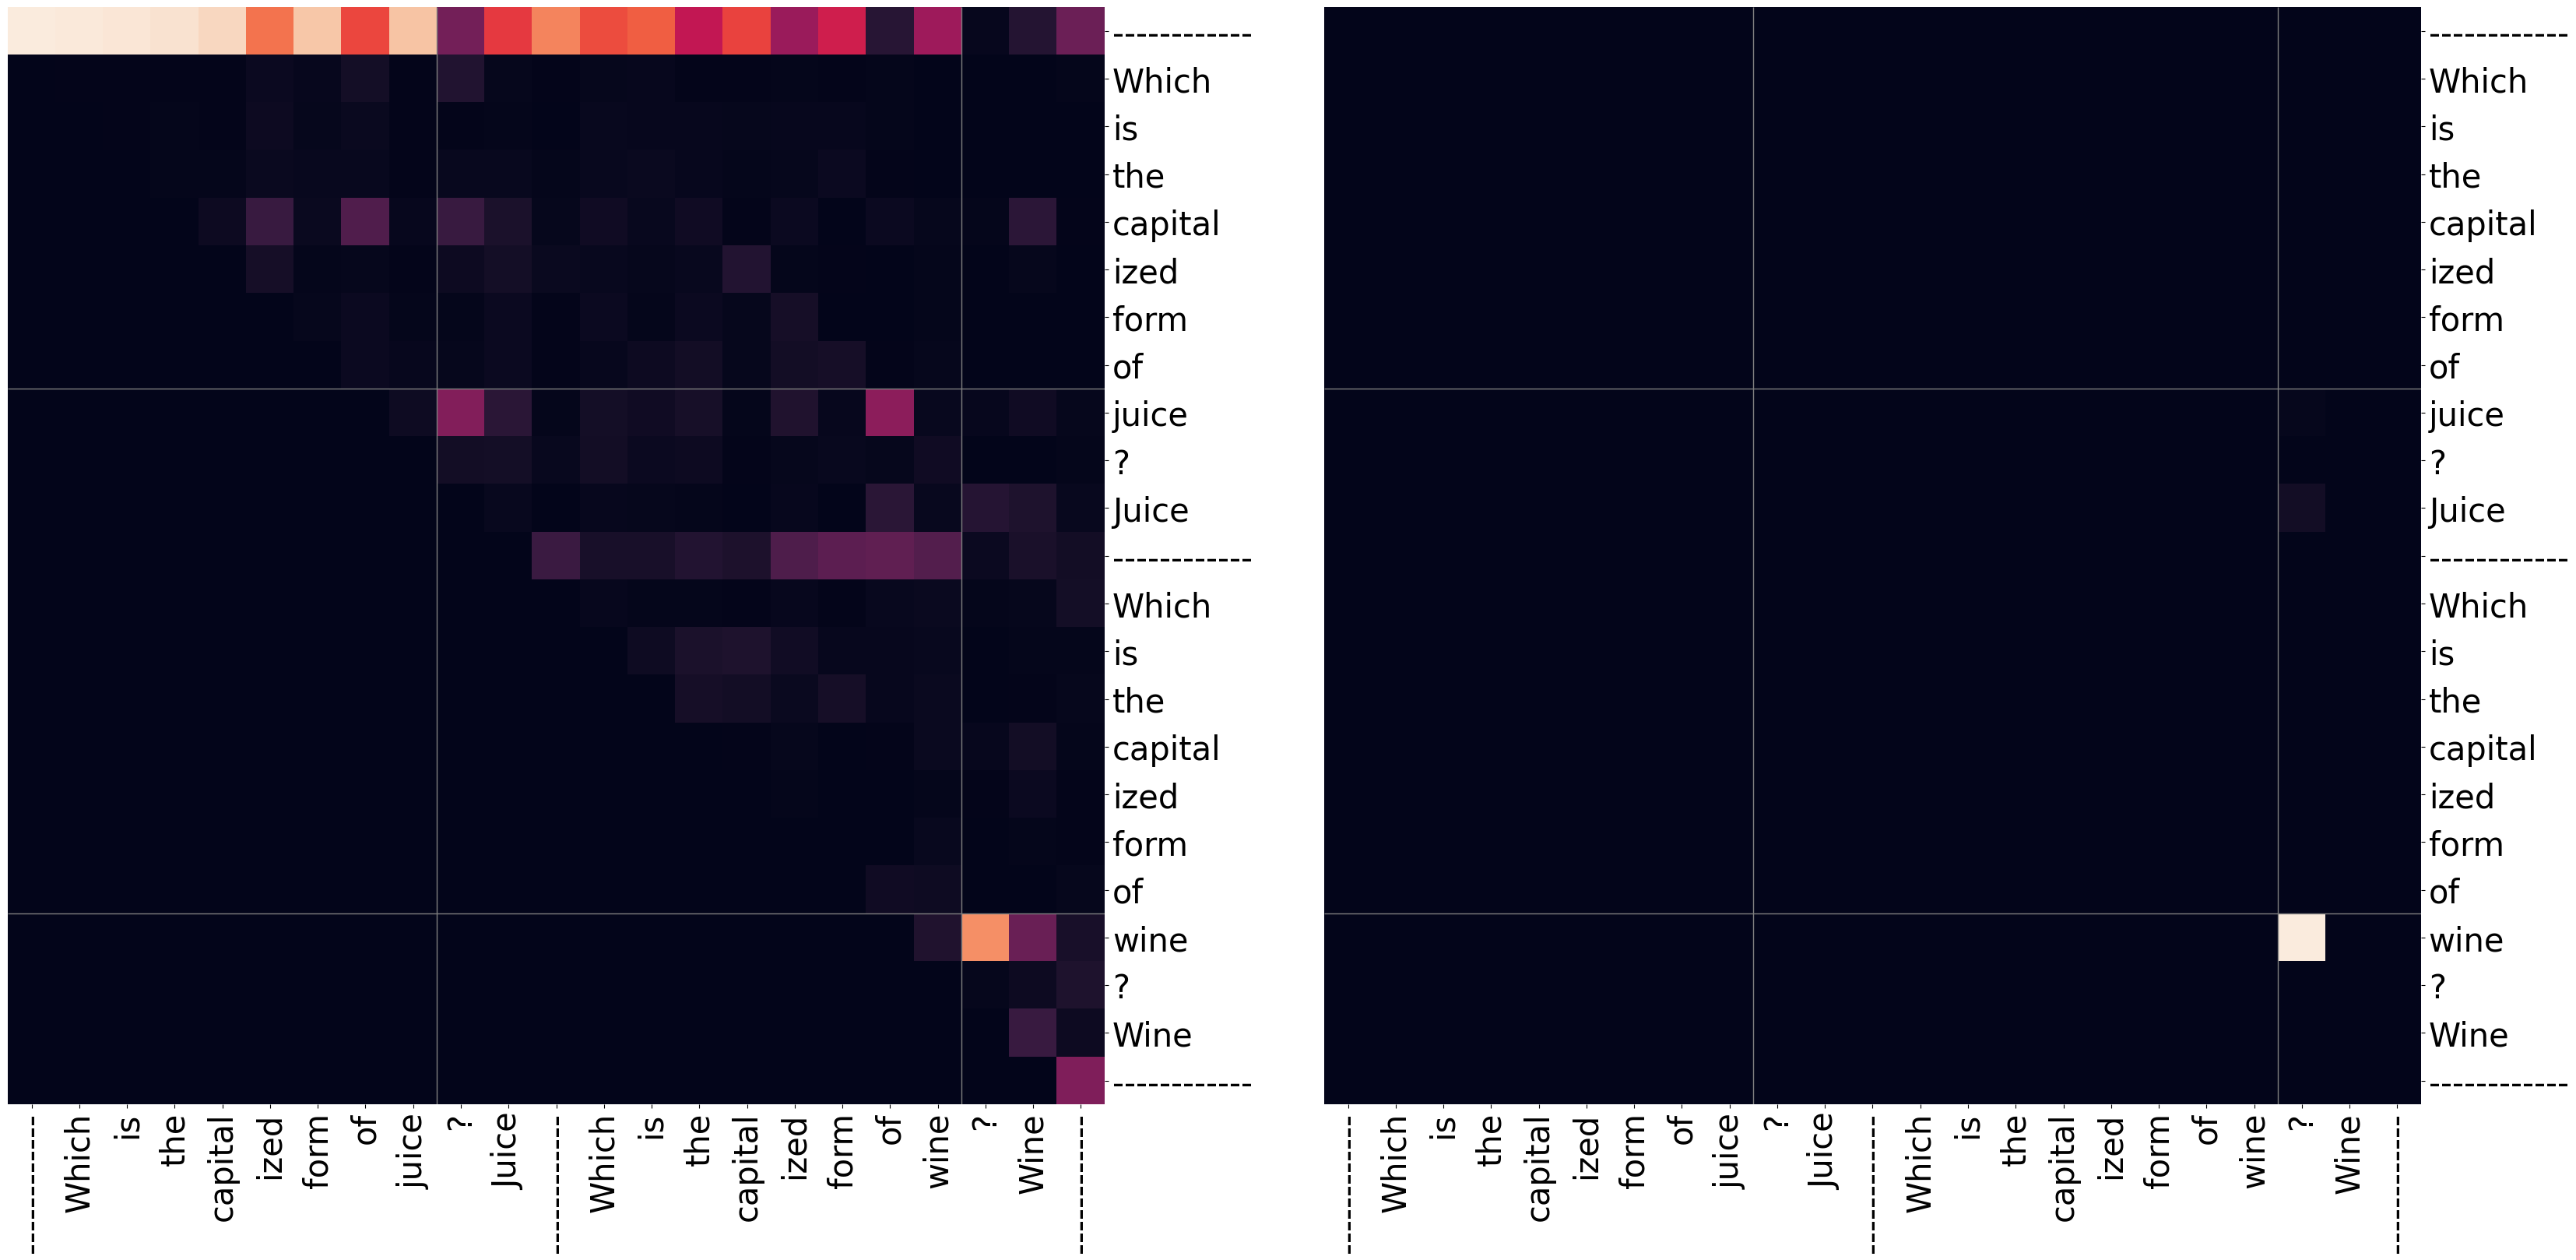

scaled_logprobs = tensor([-10.9963,  -3.7297,  -3.1620,  -3.5957])
 ĠPine 0.0 {'Ġpineapple': 0.994, 'PI': 0.002, 'PE': 0.0, 'ĠPett': 0.0} 	 Which is the capitalized form of pineapple? Pineapple 
 ĠJersey 0.027 {'ĠJC': 0.446, 'ĠJJ': 0.313, 'jer': 0.093, 'ĠJoy': 0.036} 	 Which is the capitalized form of jersey? Jersey 
3.595689296722412 0.0


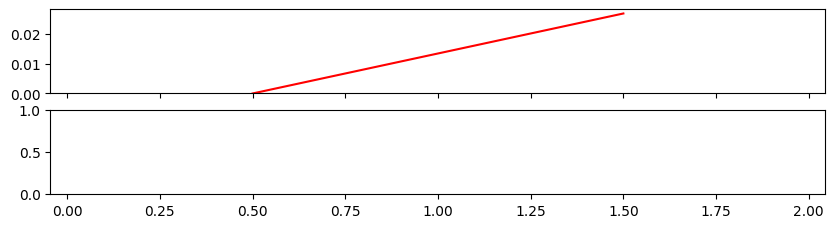

ap_scores = tensor([0.5864, 0.9455]) tensor(0.7659)


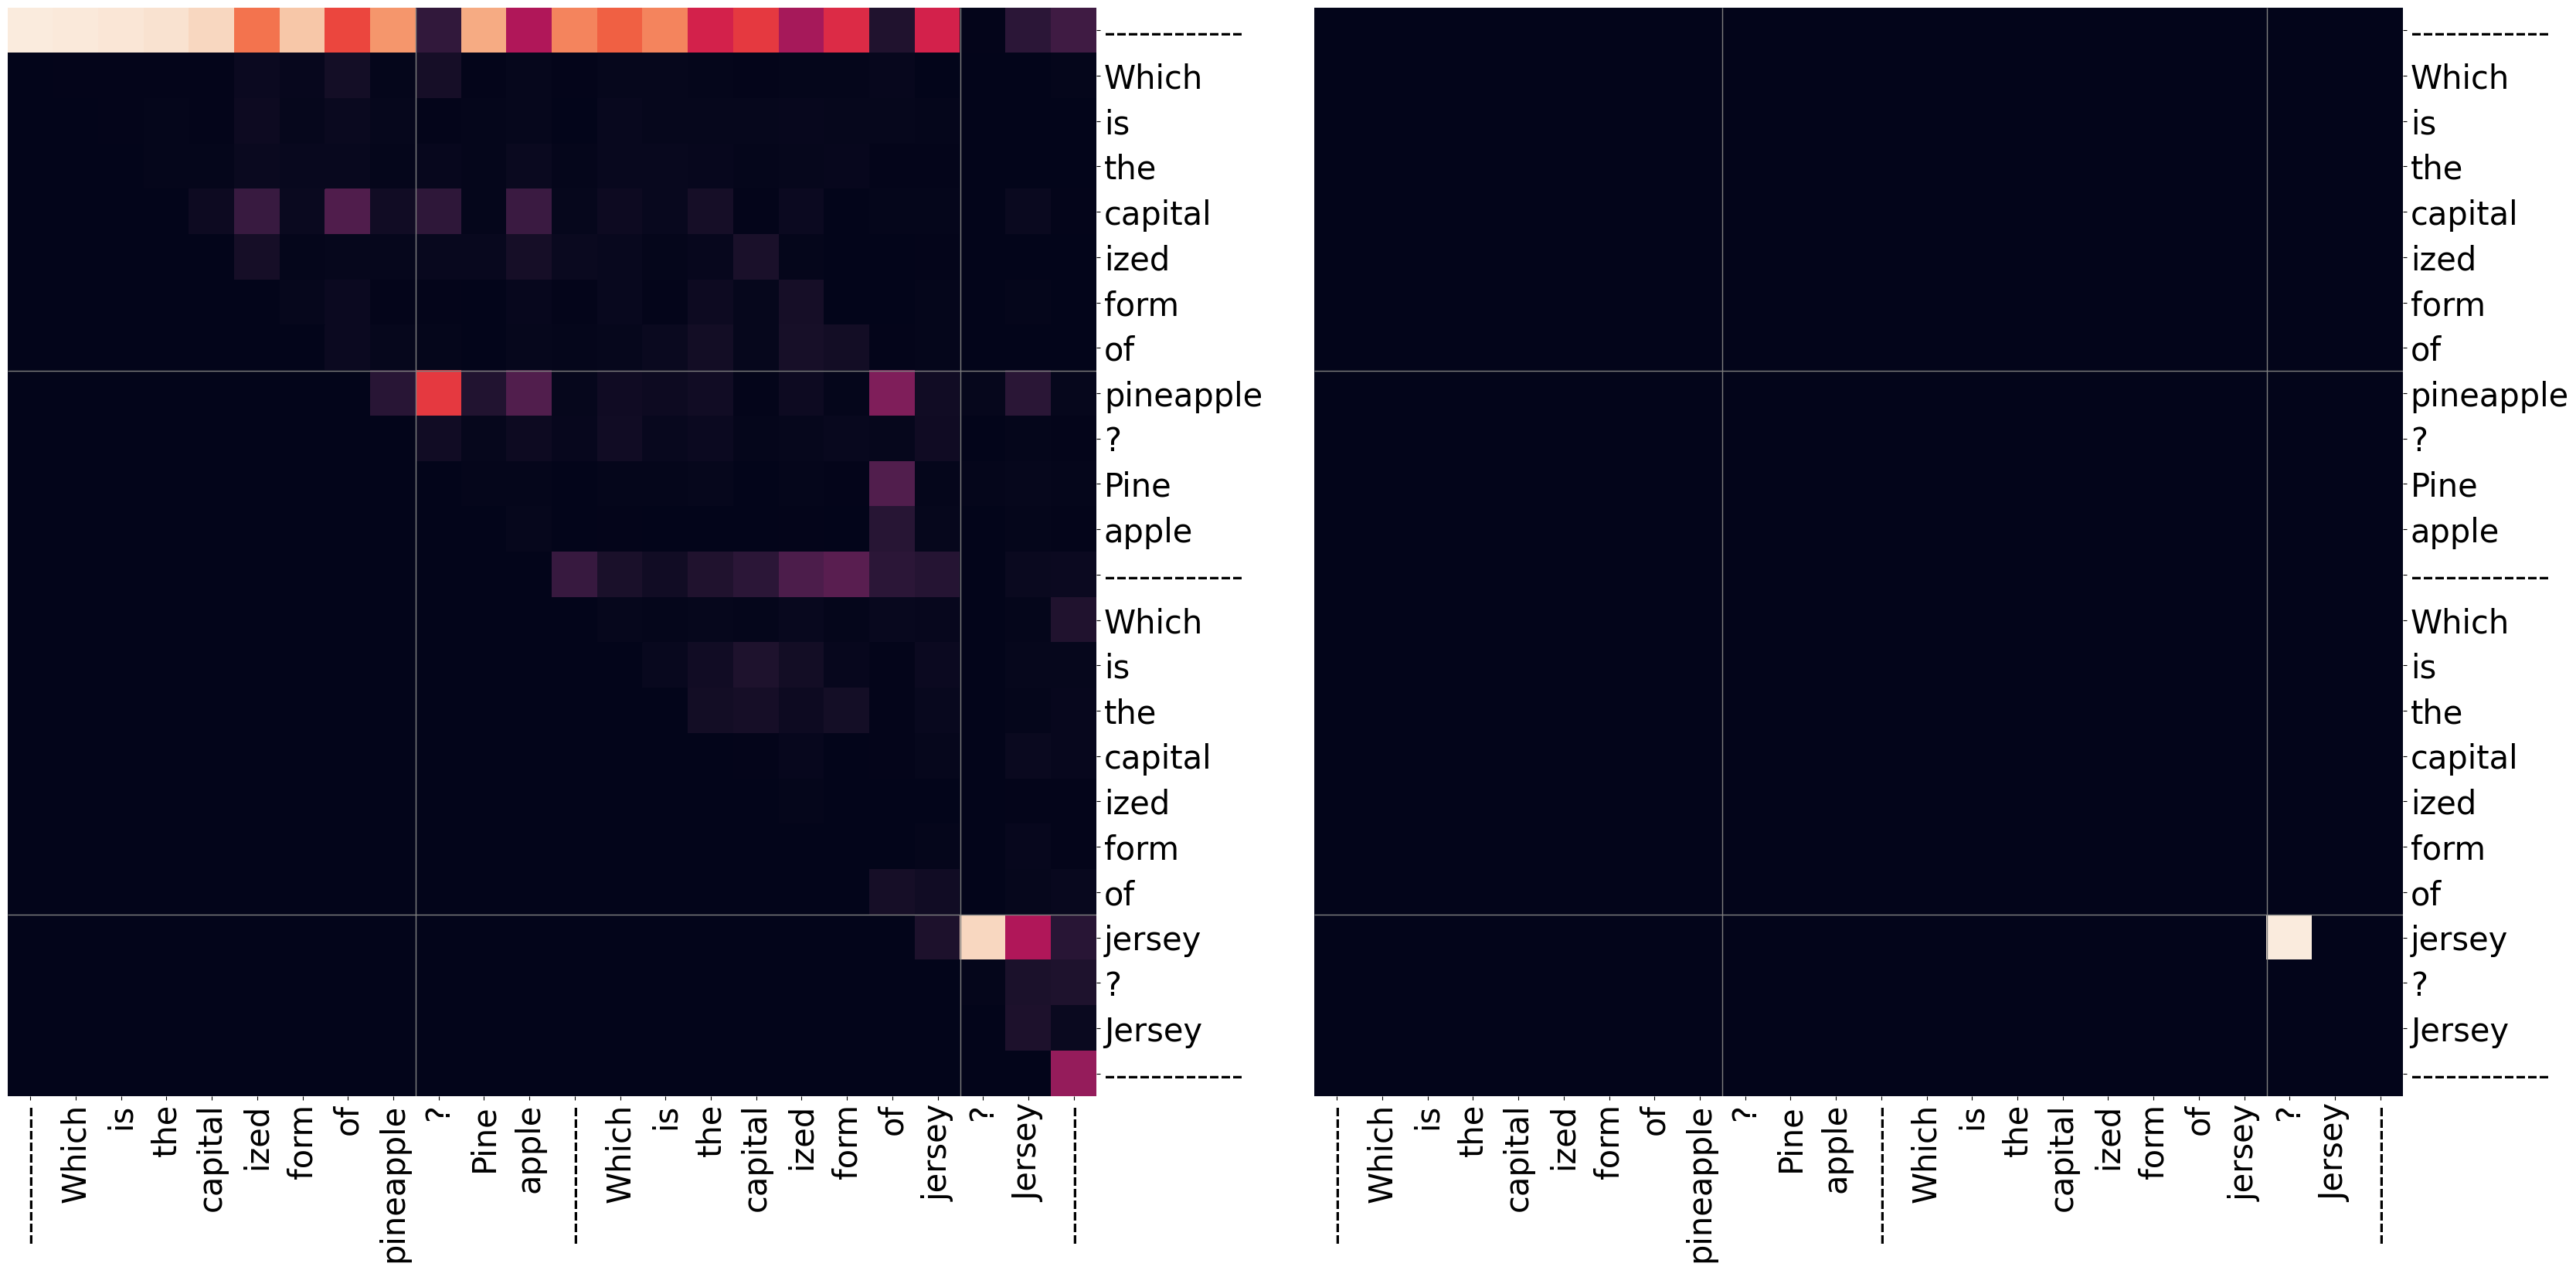

scaled_logprobs = tensor([-11.2445,  -1.7248,  -0.2881,  -0.1214])
 ĠJuice 0.033 {'ggy': 0.206, 'JV': 0.182, 'ju': 0.135, 'KI': 0.083} 	 Which is the capitalized form of juice? Juice 
*ĠTaxi 0.886 {'ĠTaxi': 0.886, 'Ġtaxi': 0.111, 'Ġtaxis': 0.002, 'ĠCaf': 0.0} 	 Which is the capitalized form of taxi? Taxi 
0.12135082483291626 1.0


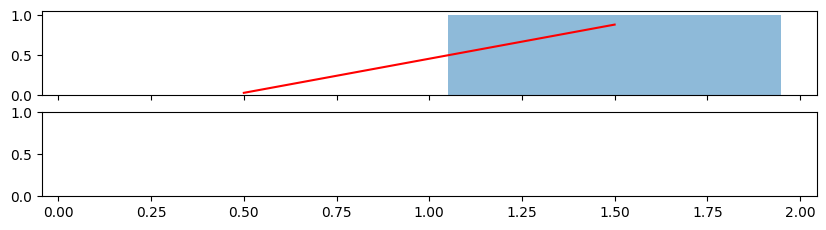

ap_scores = tensor([0.3305, 0.8963]) tensor(0.6134)


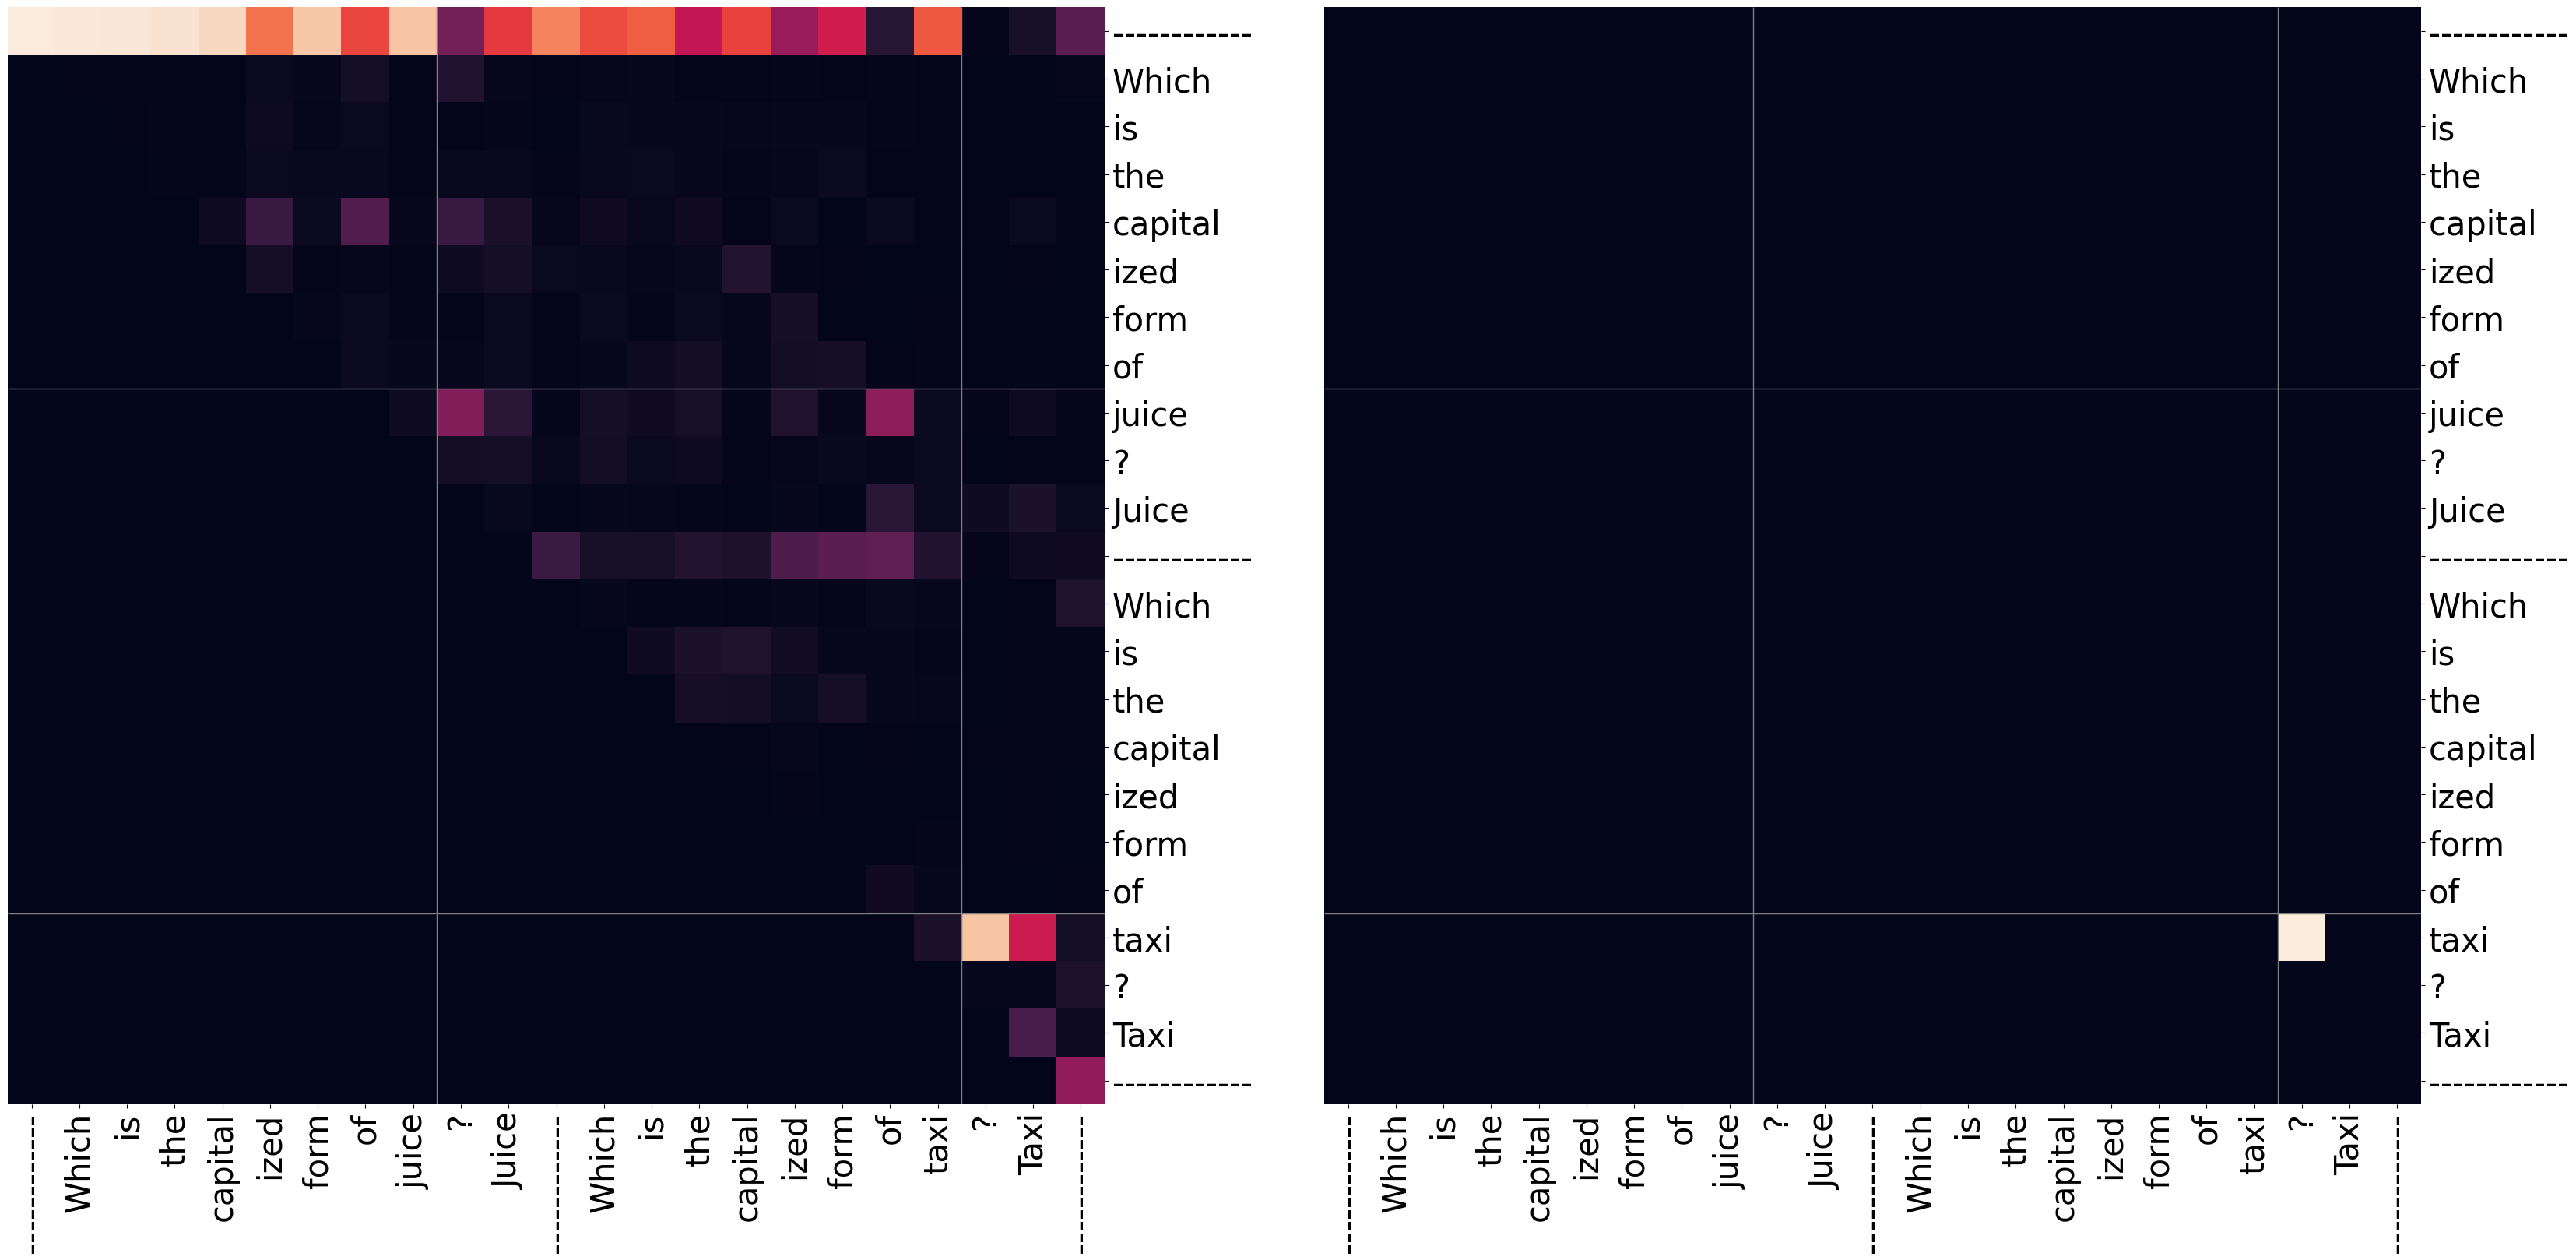

scaled_logprobs = tensor([ -9.8878,  -4.3126,  -6.7465, -10.0565])
 ĠMotor 0.001 {'ARM': 0.261, 'vier': 0.182, 'ĠMazda': 0.091, 'BAT': 0.087} 	 Which is the capitalized form of motorcycle? Motorcycle 
 ĠRed 0.0 {'redd': 0.7, 'RD': 0.18, 'RS': 0.079, 'ĠRD': 0.021} 	 Which is the capitalized form of red? Red 
10.05645751953125 0.0


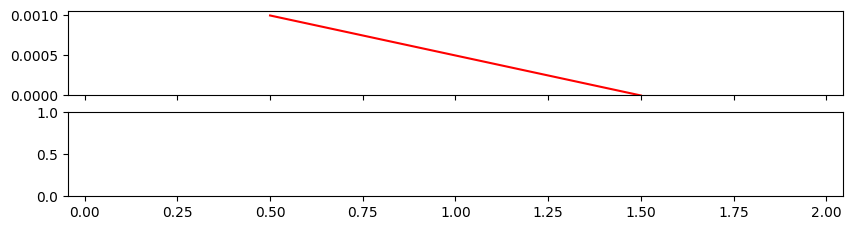

ap_scores = tensor([0.3845, 0.9234]) tensor(0.6539)


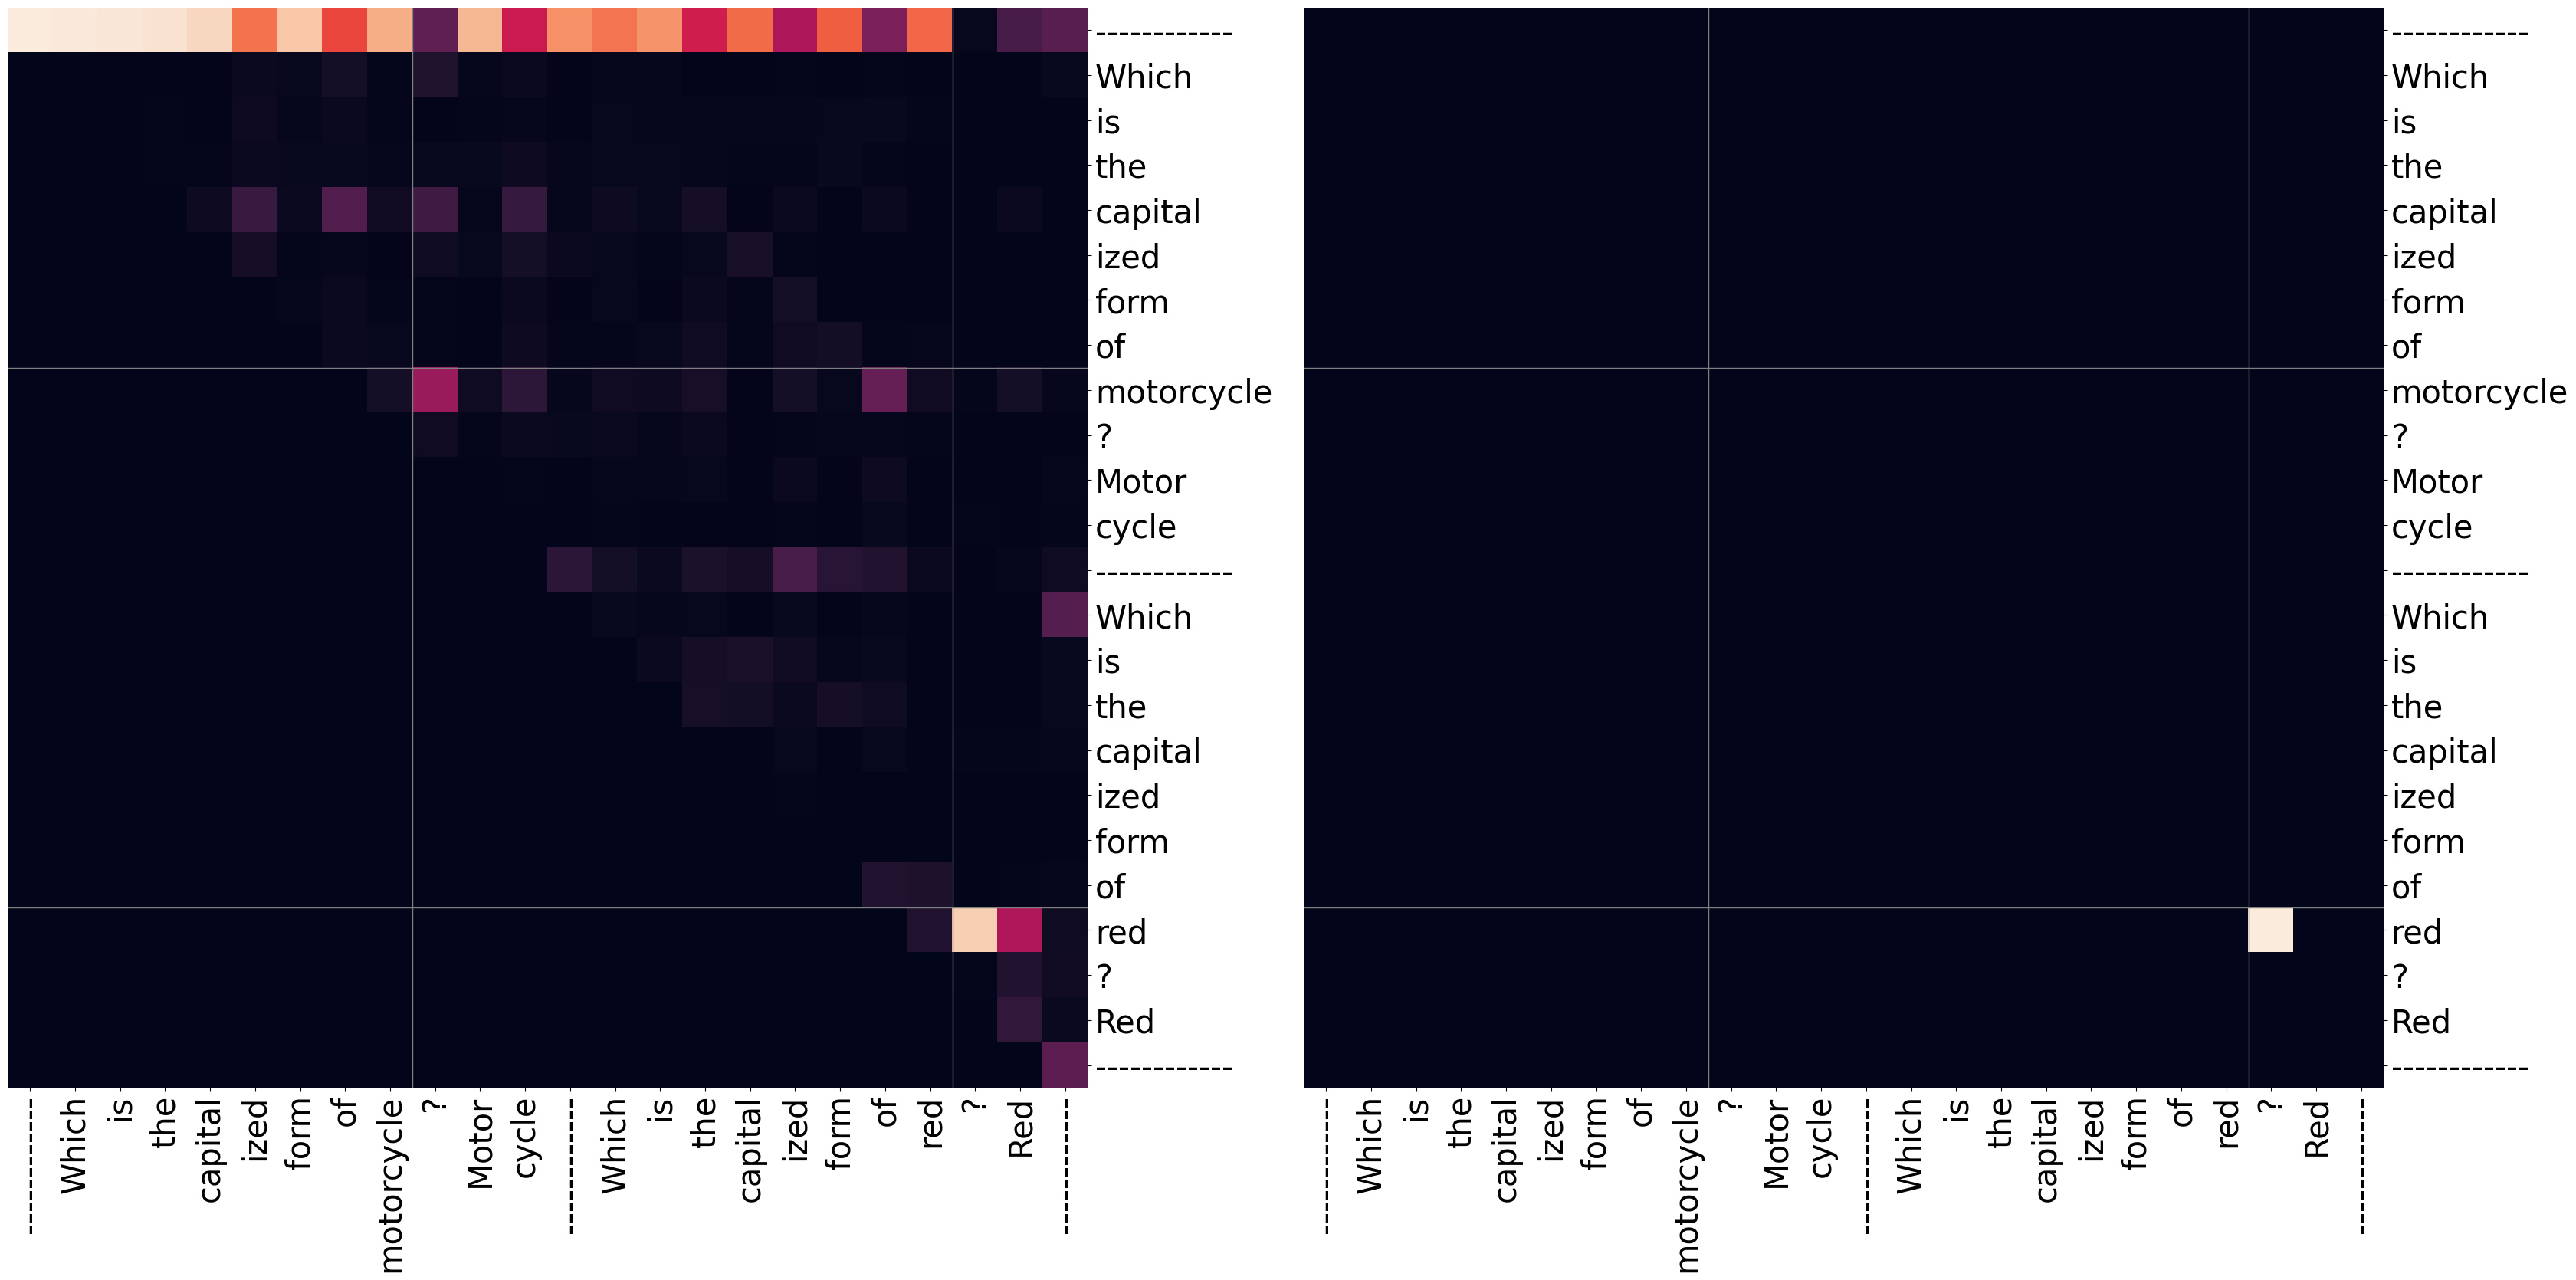

scaled_logprobs = tensor([-11.0303,  -1.7473,  -1.0568,  -1.2200])
 ĠFootball 0.003 {'FC': 0.229, 'itol': 0.122, 'etsk': 0.113, 'bart': 0.092} 	 Which is the capitalized form of football? Football 
 ĠCow 0.295 {'cow': 0.55, 'ĠCow': 0.295, 'Cow': 0.14, 'Ġcow': 0.005} 	 Which is the capitalized form of cow? Cow 
1.2199534177780151 0.0


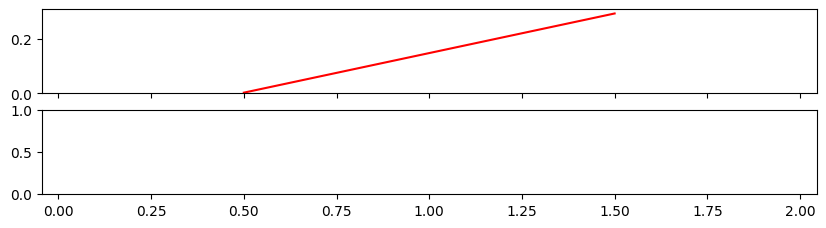

ap_scores = tensor([0.2803, 0.8773]) tensor(0.5788)


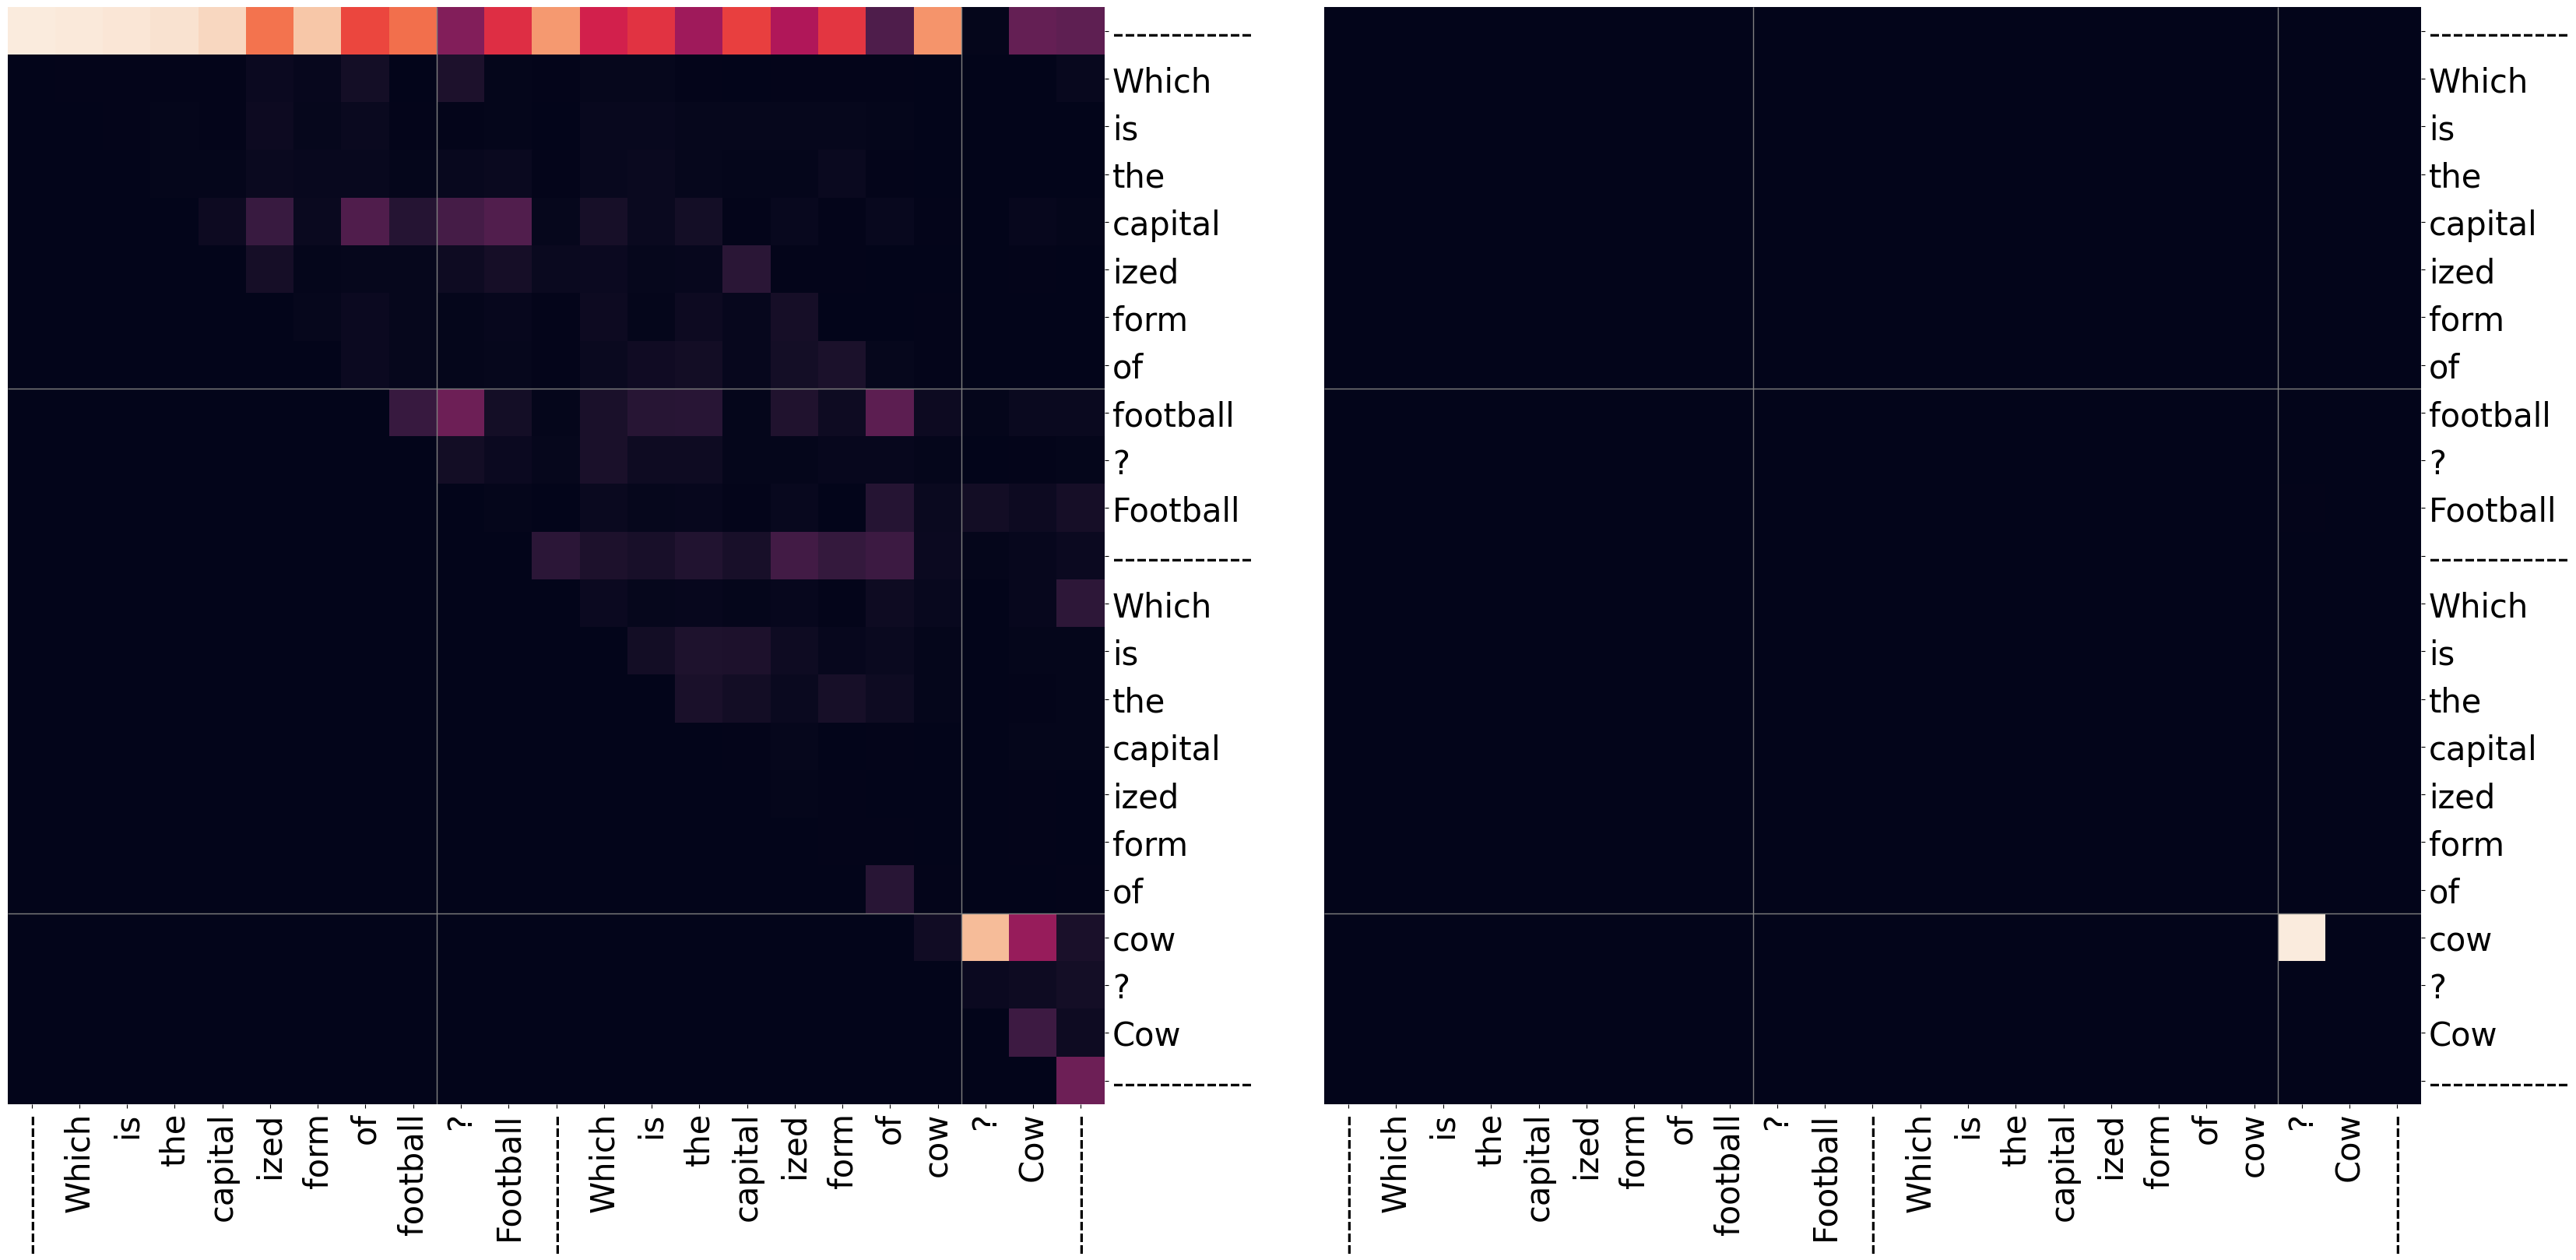

reduced_ap_scores = tensor([0.4317, 0.8692]) tensor(0.6504)


In [653]:
node = r.root; node.name
plot_attn_attrs(r.data_tuples[:8], model, tokenizer, node, topi=[1], attn_patterns=['B->Q'], k_shot=k_shot)

In [470]:
### country -> capital 

print(r.root.data.label_type)
# print(r.root.data.attr)
print(r.root.data.head_label_types)
print(r.root.data.step)
print(r.root.data.all_attn_patterns)
# for k, v in r.root.data.ap_scores.items():
#     print(k, v.shape)
print_tree(r.root)

labels
{(19, 12, 'attn_labels:bos->~<s>,3'), (8, 10, 'attn_labels:bos->~<s>,3'), (8, 1, 'attn_labels:bos->~<s>,3'), (16, 0, 'attn_labels:bos->~<s>,3')}
-1
['bos->ans0', 'bos->ans]^', 'bos->ans0+', 'bos->bos^', 'bos->bos']
 ┌@[0,1,2,4,8] 19-12,16-10,16-0,12-7,12-11 19 B->A0 45
 ├@[3,7] 17-m,19-m 28 B->B 29
 ├@[5,6] 18-3,13-13 B->A]^ 21
 ├@[9] 18-9 18 B->A0+ 9
 ├@0 19-12 100 B->A0 74/55/53/-1.7 attn/ans0s
 ├@0 19-12 100 B->A0 74/55/53/-1.7 attn:B->~<s>
 ├@0 19-12 100 B->A0 74/55/53/-1.7 attn attr_k
 ├@1 16-10 59 B->A0 86/45/-42/-1.9 attn/ans0s
 ├@1 16-10 59 B->A0 86/45/-42/-1.9 attn attr_k
 ├@2 16-0 54 B->A0 97/78/61/-1.3 attn/ans0s
 ├@2 16-0 54 B->A0 97/78/61/-1.3 attn:B->~<s>
 ├@2 16-0 54 B->A0 97/78/61/-1.3 attn attr_k
 ├@4 12-7 36 B->A0 95/48/13/-1.5 attn/ans0s
 ├@4 12-7 36 B->A0 95/48/13/-1.5 attn attr_k
 ├@162 2-11 0 B->A0/97/2 attn/ans0s
 ├@162 2-11 0 B->A0/97/2 attn:B->~<s>
 ├@162 2-8 0 B->A0/70/30 attn/ans0s
 ├@162 2-8 0 B->A0/70/30 attn:B->~<s>
 ├@162 5-6 0 B->A0/69/1 attn/ans0

In [178]:
### opposite 

print(r.root.data.label_type)
# print(r.root.data.attr)
print(r.root.data.head_label_types)
print(r.root.data.step)
print(r.root.data.all_attn_patterns)
# for k, v in r.root.data.ap_scores.items():
#     print(k, v.shape)
print_tree(r.root)


labels
{(8, 7, 'attn_labels:bos->~<s>,3'), (16, 14, 'attn_labels:bos->~<s>,3'), (11, 11, 'attn_labels:bos->~<s>,3'), (8, 1, 'attn_labels:bos->~<s>,3')}
-1
['bos->ans0', 'bos->ans]^', 'bos->ans0+', 'bos->bos^', 'bos->bos']
 ┌@[0,3,4,8] 19-m,17-m,21-m,22-m B->B 58
 ├@[1,2,5,7] 16-14,14-7,18-15,13-13 B->A0 38
 ├@[6,9] 24-7,18-9 28 B->A0+ 18
 ├@0 19-m 100
 ├@3 17-m 61
 ├@4 21-m 56
 ├@8 22-m 34
 ├@1 16-14 93 B->A0 99/96/64/-1.0 attn/ans0s
 ├@1 16-14 93 B->A0 99/96/64/-1.0 attn:B->~<s>
 ├@1 16-14 93 B->A0 99/96/64/-1.0 attn attr_k
 ├@2 14-7 64 B->A0 98/94/48/-1.0 attn/ans0s
 ├@2 14-7 64 B->A0 98/94/48/-1.0 attn attr_k
 ├@5 18-15 55 B->A0 88/43/-17/-1.5 attn/ans0s
 ├@5 18-15 55 B->A0 88/43/-17/-1.5 attn attr_k
 ├@7 13-13 36 B->A0 81/63/28/-1.0 attn/ans0s
 ├@7 13-13 36 B->A0 81/63/28/-1.0 attn attr_k
 ├@164 2-11 0 B->A0/97/2 attn/ans0s
 ├@164 2-11 0 B->A0/97/2 attn:B->~<s>
 ├@164 1-10 0 B->A0/80/-6 attn/ans0s
 ├@164 1-10 0 B->A0/80/-6 attn:B->~<s>
 ├@164 7-14 0 B->A0/73/14 attn/ans0s
 ├@164 7-

In [174]:
### thing -> kind 

print(r.root.data.label_type)
# print(r.root.data.attr)
print(r.root.data.head_label_types)
print(r.root.data.step)
print(r.root.data.all_attn_patterns)
# for k, v in r.root.data.ap_scores.items():
#     print(k, v.shape)
print_tree(r.root)

labels
{(6, 6, 'attn_labels:bos->~<s>,3'), (8, 1, 'attn_labels:bos->~<s>,3'), (11, 11, 'attn_labels:bos->~<s>,3'), (8, 10, 'attn_labels:bos->~<s>,3'), (21, 5, 'attn_labels:bos->~<s>,3'), (21, 14, 'attn_labels:bos->~<s>,3'), (13, 7, 'attn_labels:bos->~<s>,3')}
-1
['bos->ans0', 'bos->ans]^', 'bos->ans0+', 'bos->bos^', 'bos->bos']
 ┌@[1,2,3,5,9] 21-5,19-14,15-8,20-5,16-15 B->A0 50
 ├@[0,4,7] 19-m,21-m,20-m B->B 46
 ├@[6,8] 21-14,18-9 B->A0+ 16
 ├@1 21-5 89 B->A0 82/62/53/-2.0 attn/ans0s
 ├@1 21-5 89 B->A0 82/62/53/-2.0 attn:B->~<s>
 ├@1 21-5 89 B->A0 82/62/53/-2.0 attn attr_k
 ├@2 19-14 78 B->A0 93/57/47/-1.9 attn/ans0s
 ├@2 19-14 78 B->A0 93/57/47/-1.9 attn attr_k
 ├@3 15-8 63 B->A0 88/78/43/-1.4 attn/ans0s
 ├@3 15-8 63 B->A0 88/78/43/-1.4 attn attr_k
 ├@5 20-5 54 B->A0 89/54/34/-2.2 attn/ans0s
 ├@5 20-5 54 B->A0 89/54/34/-2.2 attn attr_k
 ├@9 16-15 39 B->A0 94/54/30/-2.0 attn/ans0s
 ├@9 16-15 39 B->A0 94/54/30/-2.0 attn attr_k
 ├@11 13-7 36 B->A0/73/66 attn/ans0s
 ├@11 13-7 36 B->A0/73/

## Visualization

1. plot hidden states
2. show head attention


In [441]:
r.data_tuples[0][0]

'\nWhich is the uppercase of u? U\nWhich is the uppercase of x? X\n'

In [407]:
topk= model.transformer.wte.weight.data.shape[0]
batch_logits_lens(r.data_tuples[:3], model, tokenizer, save_fig=True, task_name='country2capital', topk=topk, verbose=False, orders=[1,2], scan_layer=[])

tgt[' Athens', ' Greece']
tgt[' Moscow', ' Russia']
tgt[' Ankara', ' Turkey']
tgt[' Athens', ' Greece']


In [504]:
text = 'Bern is the capital of Switzerland\nAthens is the capital of Greece\nTokyo is the capital of'
text = 'In math, pi is 3.14. If we redefine pi as 6, then pi is'
input_ids = torch.tensor(tokenizer.encode(text))
out = model.generate(input_ids.unsqueeze(0), max_length=len(input_ids)+10)
tokens = get_tokens_from_ids(out[0].tolist(), tokenizer) 
topk= model.transformer.wte.weight.data.shape[0]
text_pred = ''.join(tokens)
print(text_pred)
token_idx = -1; tgt=['a', 'a']
outputs = forward0(model, out, by_head=['head_output'])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In math, pi is 3.14. If we redefine pi as 6, then pi is 6.

In English, the word "pi" is pronounced "pie." If we redef


In [507]:
# draw logits heatmap
_ = logits_lens((outputs, token_idx, tgt, out[0]), model, tokenizer,topk=topk, residual_types=['all', 'attn','mlp'],heatmap=True, metric='confidence')

tgt['a', 'a']



== MlM_gen[country2capital.TreeSet.equal,country2capital.TreeSet.child][cxt_len=1] == 
Bern is the capital of Switzerland
Athens is the capital of Greece
In generate_and_predict_batch: predict ... done 0:00:11.999236
0.061078480910509825 1.0


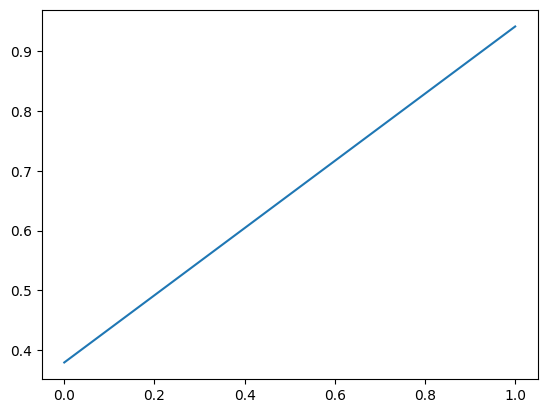


== MlM_gen[country2capital.TreeSet.child,country2capital.TreeSet.equal][cxt_len=1] == do_swap_qa
Which is the capital of Switzerland? Bern
Which is the capital of Greece? Athens
In generate_and_predict_batch: predict ... done 0:00:08.864323
0.34235959127545357 0.875


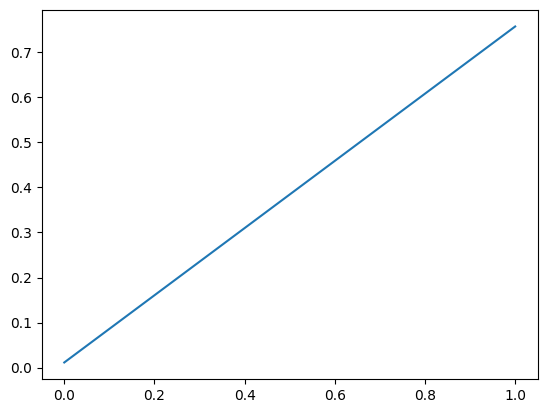

In [462]:
# batch generation
case_sensitive = True

task_names = ['capital2country','country2capital']
# task_names = ['did2do-tense','do2did-tense']
# task_names = ['do2did-day','did2do-day']
# task_names = ['up2low-word','low2up-word']
# task_names = ['up2low-letter','low2up-letter']


for batch_idx in [0]: 
    # init
    model_name = gpt_model_names[batch_idx]  # engines[4]
    model, tokenizer = models[model_name]
    model_name_gpu = model_name.replace('/cpu', '')
    model_gpu = models[model_name_gpu][0] if model_name_gpu in models else model
    blocks = model.transformer.h
    for i, b in enumerate(blocks): b.layer = i
    ln_f = model.transformer.ln_f
    L, H, embed_dim = len(blocks), blocks[0].attn.num_heads, blocks[0].attn.embed_dim
    # tasks 
    results = {}; key = None
    nrows, k_shot = 2, 1; cxt_len = 1; save_results = True
    batch_size = 8; verbose = False #not save_results or batch_size <= 8
    rel1_kwargs = {'x_f': None}  # {'x_f': _s, 'y_f': a_, 'skip_inv_f':False}
    t_cnt = 0 
    for task, rel0_i, rel1_i, do_swap_qa, do_negate, do_rm_query, rev_item2str, do_g2c in product(
        tasks[0:1], [0],[0],[False,True],  [False],[False],[False],[False]):
        seed(42)
        args = dict(cxt_len=cxt_len, rev_item2str=rev_item2str, abstract=False)
        trans_args = dict(rel0_i=rel0_i, rel1_i=rel1_i, rel1_kwargs=rel1_kwargs, do_swap_qa=do_swap_qa, do_negate=do_negate,
                          do_rm_query=do_rm_query, do_g2c=do_g2c)
        task = transform_and_validate_task(task, **trans_args, **args)
        if task is None: continue
        res_key = f'{task2str(task)}[{args2str(args)}]'
        print(f'\n== {res_key} == {args2str(trans_args)}')
    #     if key is not None and res_key != key: continue
        r = results[res_key] if save_results and res_key in results else None
    #     if r is not None: print('duplicate task!'); continue 
        r = generate_and_predict_batch(model if save_results else model_gpu, tokenizer, task, nrows, k_shot, batch_size,
                custom_forward=save_results, result=r, verbose=verbose, **args)
        if save_results: results[res_key] = r
#         if not save_results or getattr(r, 'mean_acc', 0) < 0.45: continue

        if True or r.root is None: r.root = add_node(None, layer=L, label_type='labels')
#         r.root = attribute_tree_on(r.data_tuples, model, r.root, 1, topk=10, k_shot=k_shot, mix=True, device=device, verbose=True)
#         topk= model.transformer.wte.weight.data.shape[0]
#         batch_logits_lens(r.data_tuples[:8], model, tokenizer, case_sensitive=case_sensitive, save_fig=True, task_name=task_names[t_cnt], topk=topk, verbose=False, orders=[1,2], scan_layer=[])
        t_cnt +=1

In [329]:
topk= model.transformer.wte.weight.data.shape[0]
batch_logits_lens(r.data_tuples[:8], model, tokenizer, topk=topk, verbose=False, orders=[1,2], scan_layer=[])

two tokens in query or target [' Seoul', ' South'] 
Which is the capital of Switzerland? Bern
Which is the capital of South Korea? Seoul

tgt[' Athens', ' Greece']
tgt[' Moscow', ' Russia']
tgt[' Ankara', ' Turkey']
tgt[' Canberra', ' Australia']
tgt[' Ankara', ' Turkey']
tgt[' Bern', ' Switzerland']
tgt[' Seoul', ' South']
tgt[' Delhi', ' India']


In [318]:
len(np.arange(0,len(model.transformer.h)+1))

29

In [642]:
# show head attention 
dt = r.data_tuples[0]
html = show_interactive_heads(dt[-1],dt[1][0], tokenizer, layer=19, head=15)
html

layer:19, head:15, token:None


In [508]:
import plotly.offline as pyo
pyo.init_notebook_mode()

In [618]:
show_hidden_traj(r.data_tuples[:8], tokenizer, hid_type='hidden_states', selector=['run'],perplexity=100, metric='cosine')
# show_hidden_traj(r.data_tuples[:8], tokenizer, hid_type='head_outputs', layer_heads=[(8,1),(13,13),(9,13),(11,11)], layer_slice=None, head_slice=None, selector=['h'],perplexity=100, metric='cosine')

torch.Size([3648, 1024]) 3648 hidden_states 24 16 19
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 3648 samples in 0.005s...


/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



[t-SNE] Computed neighbors for 3648 samples in 0.522s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3648
[t-SNE] Computed conditional probabilities for sample 2000 / 3648
[t-SNE] Computed conditional probabilities for sample 3000 / 3648
[t-SNE] Computed conditional probabilities for sample 3648 / 3648
[t-SNE] Mean sigma: 0.062138
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.203510
[t-SNE] KL divergence after 1000 iterations: 0.553268


In [565]:
logits_lens(data_tuple[-1], model, tokenizer, residual_types=['mlp','attn'], topk=50400, token_idx=token_idx, tgt=tgt, topk_out=5)

-1-None-mlp rank:0.0001 logit_diff:0.0 logits1.4 Ġutter-6.8_Ġheated-6.7_Ġcontrolled-6.7_gars-6.5_Ġsimultaneously-5.9
-1-None-attn rank:0.0000 logit_diff:0.0 logits0.8 Content-13.0_Reference-12.4_param-12.0_Input-12.0_Const-11.8
0-None-mlp rank:0.0001 logit_diff:0.0 logits1.8 Ġimport-6.9_gars-6.8_Ġfounding-6.6_Ġstill-6.4_Ġbuilding-6.4
0-None-attn rank:0.0002 logit_diff:0.0 logits3.0 atures-7.7_Ġbait-7.5_Ġutter-7.3_Ġautomatic-7.2_Ġacid-7.1
1-None-mlp rank:0.0001 logit_diff:0.0 logits1.3 Ġwords-7.5_Ġ:-7.3_Ġsimultaneously-7.2_Ġcontrolled-7.1_Ġerror-7.1
1-None-attn rank:0.0002 logit_diff:0.0 logits3.2 Ġcontrolled-9.2_Ġenc-8.8_Ġeconomy-8.5_Ġwords-8.3_Ġan-8.2
2-None-mlp rank:0.0000 logit_diff:0.0 logits1.3 Ġwords-8.8_Ġexpression-8.4_Ġcontrol-8.3_ature-8.2_Ġcontrolling-8.1
2-None-attn rank:0.0001 logit_diff:0.0 logits3.1 Ġwords-10.8_Ġexpression-10.6_Ġder-10.4_Ġcontrolled-10.0_Ġparent-10.0
3-None-mlp rank:0.0001 logit_diff:0.0 logits1.6 Ġspeech-10.1_Ġexpression-10.0_Ġwords-9.6_Ġstill-9.1_Ġcontr

In [44]:
r.data_tuples[1][3][-1]
r.data_tuples[1][0]
r.data_tuples[1][1].shape

Ranges(bos=(16, 17), ans=(17, 18), ans0=None, query=(15, 16), tgt=None, rel=(13, 14), sep=None, ans0s=None, example=(10, 18))

'\nWhich is the capital of France? Paris\nWhich is the capital of Russia? Moscow\n'

torch.Size([1, 19])

In [71]:
data_tuple = r.data_tuples[1]
token_idx = -3; tgt= [' Moscow', ' Russia'] #' Greece', ' Russia';
topk= model.transformer.wte.weight.data.shape[0]
str_tokens = get_tokens_from_ids(data_tuple[1][0], tokenizer)
print('subsequent tokens', str_tokens[token_idx:])
print(' '.join(str_tokens))

fig =logits_lens((data_tuple[-1],token_idx, tgt), model, tokenizer, residual_types=['all', 'mlp', 'attn'], topk=topk, topk_out=5,scan_layer=[], plot_ranks=True)
fig.show()

subsequent tokens ['?', ' Moscow', '______________']
______________ Which  is  the  capital  of  France ?  Paris ______________ Which  is  the  capital  of  Russia ?  Moscow ______________
-1-all-all rank:0.0000 logit_diff:-2.7 logits-4.8 ACP-9.5_416-8.7_ENG-8.7_AM-8.6_ĠKiw-8.6
-1-mlp-all rank:0.0000 logit_diff:-0.6 logits-0.9 Ġalready-7.2_Ġstill-7.1_ĠCor-7.1_Ġcolor-6.9_Ġalso-6.7
-1-attn-all rank:0.0000 logit_diff:-2.2 logits-0.2 ACP-10.5_Ġactors-9.6_Ġmarks-9.3_ĠEthiop-9.3_ARA-9.3
0-all-all rank:0.0000 logit_diff:-0.9 logits-0.7 Ġalready-7.6_Ġstill-7.1_ĠCor-7.0_php-6.8_Ġallocate-6.7
0-mlp-all rank:0.0000 logit_diff:-0.7 logits-0.2 Ġalready-8.1_Ġstill-7.9_ĠCor-7.5_Ġsometimes-7.4_ĠStr-7.3
0-attn-all rank:0.0000 logit_diff:-0.8 logits-0.5 Ġstill-7.2_ĠStr-7.1_Ġenc-6.8_Ġraces-6.7_Ġalready-6.7
1-all-all rank:0.0000 logit_diff:-0.5 logits0.1 ĠStr-8.2_Ġstill-8.0_ĠOr-7.8_Ġalready-7.3_ĠCor-7.2
1-mlp-all rank:0.0000 logit_diff:-0.4 logits0.6 ĠStr-8.5_ĠOr-8.3_ĠId-7.8_ĠAnd-7.6_ĠAt-7.5
1-attn-all ra

24-mlp-all rank:1.0000 logit_diff:9.5 logits29.9 ĠMoscow-29.9_ĠSt-26.3_ĠSaint-22.4_ĠPetersburg-22.4_ĠLondon-21.7
24-attn-all rank:1.0000 logit_diff:10.9 logits35.1 ĠMoscow-35.1_Moscow-25.6_ĠPetersburg-25.1_ĠKiev-24.4_ĠRussia-24.2
25-all-all rank:1.0000 logit_diff:9.6 logits30.3 ĠMoscow-30.3_ĠSt-26.3_ĠPetersburg-22.7_ĠSaint-22.6_ĠLondon-22.0
25-mlp-all rank:0.5000 logit_diff:7.2 logits25.6 ĠSt-25.7_ĠMoscow-25.6_ĠSaint-21.4_ĠL-21.3_Ċ-20.3
25-attn-all rank:1.0000 logit_diff:9.3 logits30.4 ĠMoscow-30.4_ĠSt-25.7_ĠPetersburg-22.8_ĠSaint-22.2_ĠLondon-22.1
26-all-all rank:1.0000 logit_diff:7.0 logits25.7 ĠMoscow-25.7_ĠSt-25.1_ĠL-21.1_ĠSaint-21.1_Ċ-20.4
26-mlp-all rank:1.0000 logit_diff:6.2 logits20.6 ĠMoscow-20.6_ĠSt-18.5_ĠSaint-16.6_ĠMos-15.9_ĠPetersburg-15.8
26-attn-all rank:1.0000 logit_diff:6.8 logits25.6 ĠMoscow-25.6_ĠSt-24.9_ĠSaint-20.9_ĠL-20.8_Ċ-20.4


In [146]:
o = r.data_tuples[0][-1]
len(o.hidden_states), len(o.attn_outputs), type(o.attn_outputs)
for i, (h, h_attn, h_mlp, h_heads) in enumerate(zip(o.hidden_states, o.attn_outputs+[0], o.mlp_outputs+[0], o.head_outputs+[0])):
    print(i)

(30, 28, tuple)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-146-e7de12602171>:3 in <module>                                            │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: can only concatenate tuple (not "list") to tuple

In [83]:
r.data_tuples[0][3]

[Ranges(bos=(7, 8), ans=(8, 9), ans0=None, query=(6, 7), tgt=None, rel=(4, 5), sep=None, ans0s=None, example=(1, 9)),
 Ranges(bos=(16, 17), ans=(17, 18), ans0=None, query=(15, 16), tgt=None, rel=(13, 14), sep=None, ans0s=None, example=(10, 18))]

In [31]:
a, b =map(torch.tensor, [[2], []])

In [53]:
torch.stack([torch.tensor([ 0.0000, -0.4324]), torch.tensor([0.0000, 0.0979])])

tensor([[ 0.0000, -0.4324],
        [ 0.0000,  0.0979]])

In [150]:
np.arange(-1,28)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [319]:
def contains(t, l):
    return any([i in t for i in l])

In [245]:
# show word embedding 
print(model.transformer.wte.weight.data.shape)
iids = torch.tensor(torch.range(0,50399,dtype=int))
sub_idxs = torch.randint(0,50399, (10000,))
iids = iids[sub_idxs]
input_emb = model.transformer.wte.weight.data[iids,:]
iids = iids.tolist()
# tokenizer.convert_ids_to_tokens([0,1])
# print(len(iids))
token_str = get_tokens_from_ids(iids)
# print(token_str[:100])
# 
tsne = TSNE(n_components=2, verbose=1, random_state=0, metric='cosine')
z_emb = tsne.fit_transform(input_emb)

torch.Size([50400, 4096])
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.052s...


/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning:

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).

/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/nas/shawn_guo/m

[t-SNE] Computed neighbors for 10000 samples in 3.481s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.015520
[t-SNE] KL divergence after 250 iterations with early exaggeration: 139.234985
[t-SNE] KL divergence after 1000 iterations: 4.764591


In [329]:
words = []
with open('google-10000-english.txt', 'r') as f:
    for l in f.readlines():
        words.append(l.replace('\n',''))
    

In [331]:
words[:10]
tokenizer.encode(words[:10])

['the', 'of', 'and', 'to', 'a', 'in', 'for', 'is', 'on', 'that']

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ <ipython-input-331-4d4d188aef0e>:2 in <module>                                            │
│ /nas/xd/projects/transformers/src/transformers/tokenization_utils_base.py:2328 in encode  │
│                                                                                           │
│   2325 │   │   │   max_length=max_length,                                                 │
│   2326 │   │   │   stride=stride,                                                         │
│   2327 │   │   │   return_tensors=return_tensors,                                         │
│ ❱ 2328 │   │   │   **kwargs,                                                              │
│   2329 │   │   )                                                                          │
│   2330 │   │                                                                              │
│   2331 │   │   return encoded_inputs["input_ids"]                                         │
│                                                                                           │
│ /nas/xd/projects/transformers/src/transformers/tokenization_utils_base.py:2745 in         │
│ encode_plus                                                                               │
│                                                                                           │
│   2742 │   │   │   return_offsets_mapping=return_offsets_mapping,                         │
│   2743 │   │   │   return_length=return_length,                                           │
│   2744 │   │   │   verbose=verbose,                                                       │
│ ❱ 2745 │   │   │   **kwargs,                                                              │
│   2746 │   │   )                                                                          │
│   2747 │                                                                                  │
│   2748 │   def _encode_plus(                                                              │
│                                                                                           │
│ /nas/xd/projects/transformers/src/transformers/models/gpt2/tokenization_gpt2_fast.py:178  │
│ in _encode_plus                                                                           │
│                                                                                           │
│   175 │   │   │   "to use it with pretokenized inputs."                                   │
│   176 │   │   )                                                                           │
│   177 │   │                                                                               │
│ ❱ 178 │   │   return super()._encode_plus(*args, **kwargs)                                │
│   179 │                                                                                   │
│   180 │   def save_vocabulary(self, save_directory: str, filename_prefix: Optional[str] = │
│   181 │   │   files = self._tokenizer.model.save(save_directory, name=filename_prefix)    │
│                                                                                           │
│ /nas/xd/projects/transformers/src/transformers/tokenization_utils_fast.py:517 in          │
│ _encode_plus                                                                              │
│                                                                                           │
│   514 │   │   │   return_offsets_mapping=return_offsets_mapping,                          │
│   515 │   │   │   return_length=return_length,                                            │
│   516 │   │   │   verbose=verbose,                                                        │
│ ❱ 517 │   │   │   **kwargs,                                                               │
│   518 │   │   )                                                                           │
│   519 │   │                                       

In [82]:
import dataclasses
print(len(r.data_tuples))
outputs = r.data_tuples[0][-1]
fields = dataclasses.fields(outputs)
# print(fields)
for fd in fields:
#     print(fd.name)
    v = getattr(outputs, fd.name)
#     print(fd.name, type(v))
    if isinstance(v, torch.Tensor):
        print(fd.name, v.shape)
    elif isinstance(v, tuple) and len(v) >0:
        print(fd.name, len(v),v[0].shape)
    elif isinstance(v, dict):
        print(fd.name, v.keys())
    else:
        print(fd.name, v)
    
#    print(outpuddtsfd)

2
inputs_embeds torch.Size([1, 209, 4096])
position_embeds None
attn_outputs 28 torch.Size([1, 209, 4096])
values 28 torch.Size([1, 16, 209, 256])
attn_outs 28 torch.Size([1, 16, 209, 256])
head_inputs None
head_outputs None
intermediates ()
mlp_outputs 28 torch.Size([1, 209, 4096])
hidden_states 30 torch.Size([1, 209, 4096])
attentions 28 torch.Size([1, 16, 209, 209])
logits torch.Size([1, 209, 50400])
labels None
loss None
attn_attr odict_keys(['', '16-7,16-0 attn attr_k', '16-7,16-0 attn/ans0s', '16-7,16-0 attn:B->~<s>', '24-10 attn:B->~<s>', '24-10'])


In [50]:
'''
print AttrData and Attributions
'''

attrdata = r.root.data
fields = dataclasses.fields(attrdata)
for fd in fields:
#     print(fd.name, type(getattr(attrdata, fd.name)))
    v = getattr(attrdata, fd.name)
    if isinstance(v, dict):
        print(fd.name, [[_k,(_v.shape if isinstance(_v, torch.Tensor) else _v)] for _k,_v in v.items()])
    else:
        print(fd.name, v if not isinstance(v, Attributions) else 'attr'  )
print('--------------Attributions-----------------')
attribution = attrdata.attr 
fields = dataclasses.fields(attribution)
for fd in fields:
    v = getattr(attribution, fd.name)
    print(fd.name, v if not isinstance(v, torch.Tensor) else v.shape)

'\nprint AttrData and Attributions\n'

step -1
topi None
layer 28
head None
H 64
label_type labels
attn_pattern None
attribute_k False
attr attr
ap_scores [['bos->ans0', torch.Size([28, 16])], ['bos->ans]', torch.Size([28, 16])], ['bos->query', torch.Size([28, 16])], ['bos->ans0+', torch.Size([28, 16])], ['bos->tgt', torch.Size([28, 16])], ['bos->sep', torch.Size([28, 16])], ['bos->sep+', torch.Size([28, 16])], ['bos->query-', torch.Size([28, 16])], ['bos->bos', torch.Size([28, 16])]]
head_label_types {(16, 7, 'attn_labels:bos->~<s>,3'), (13, 7, 'attn_labels:bos->~<s>,3'), (17, 9, 'attn_labels:bos->~<s>,3'), (18, 13, 'attn_labels:bos->~<s>,3'), (19, 4, 'attn_labels:bos->~<s>,3'), (16, 0, 'attn_labels:bos->~<s>,3')}
attr_ap_scores [['bos->ans0', {(18, 13): tensor(0.9330), (16, 7): tensor(0.9523), (13, 7): tensor(0.9237), (16, 0): tensor(0.9425), (23, 14): tensor(0.9308), (19, 4): tensor(0.8385), (18, 9): tensor(0.0857), (17, 9): tensor(0.9146), (21, 13): tensor(0.9429), (20, 1): tensor(0.4251)}], ['bos->ans]', {(18, 13): ten

In [83]:
node = node.parent.parent

NameError: name 'node' is not defined

In [ ]:
print(key); node = result.node = add_node(node, layer=16, head=7, topi=[0], head_attr_fn=get_head_mlp_attr)#, label_type=f'argmax_attn_labels')  # 

In [ ]:
print(key); node = result.node = add_node(node, topi=[0], head_attr_fn=get_head_mlp_attr)#, label_type=f'argmax_attn_labels')

### fr->en

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
print(key); node = result.node = add_node(node, topi=[0,1,2,3,4,5])

In [ ]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, en2fr.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
plot_attn_attrs(data_tuples, model, tokenizer, node, topi=[0,1,2], k_shot=k_shot)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2], label_type='argmax_attn_labels')  # head_attr_fn=get_head_mlp_attr

In [ ]:
analyze_head_chains(model, get_head2scores(result.root.children[1].children[0].children[0]))

### did->does

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node.parent.parent.parent, topi=[0,1], head_attr_fn=get_head_mlp_attr, mix=True)

In [ ]:
for text, input_ids, labels, ranges, *args, o in data_tuples:
    show_predictions(tokenizer, *args, logits=o.logits, labels=labels, k_shot=k_shot, topk=3)[0]

In [ ]:
result.node = result.node.parent.parent.parent
result.node = result.root

In [ ]:
print(key); node = add_node_to_result(result, topi=[1,0,2,7], head_attr_fn=get_head_mlp_attr, label_type='attn_labels')  # head_attr_fn=get_head_mlp_attr

In [ ]:
for data_tuple in data_tuples:
    plot_attn_attr(data_tuple, model, tokenizer, node, 17, 16, attn_patterns=None, k_shot=0, plot_attr=False)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node.parent, topi=[0,1,6,7,10])

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 1, 2], k_shot=k_shot)  # head_attr_fn=get_head_mlp_attr

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=10)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 7], head_attr_fn=get_head_mlp_attr)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3])

In [ ]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, does2did.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result, topk=15)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3], label_type='attn_labels')  # head_attr_fn=get_head_mlp_attr, 

### thing->capability

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1, 2])

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1])

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[2,1,3,0])

In [ ]:
analyze_head_chains(model, get_head2scores(node));

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, capabilities_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
for text, input_ids, labels, ranges, *args, o in data_tuples:
    loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
        tokenizer, *args, logits=o.logits, labels=labels, loss_reduction='mean',
        candidates=None, k_shot=k_shot, topk=3, verbose=True)
    print(loss)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node.parent.parent.parent, topi=[0], k_shot=k_shot)

In [ ]:
plot_attn_attrs(data_tuples[:4], model, tokenizer, node, topi=[0, 1, 2, 3], k_shot=k_shot, plot_attr=False)

In [ ]:
print(key); node = add_node_to_result(result, topi=[1,2,0], label_type='argmax_attn_labels')

### capital->country

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
interpret_circuit(model, tokenizer, result.task, node, topi=[0, 1, 2])

In [ ]:
print(key); node = add_node_to_result(result, topi=[0])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, country2capital.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='argmax_attn_labels')

### person_adjs.opposite

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2,3,4])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, person_adjs.SymSet.opposite) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,])#, label_type='attn_labels')

### thing->type

In [ ]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")  # old full

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[1, 2])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0, 1, 2, 3, 4])

In [ ]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [ ]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='attn_labels')

In [ ]:
# seed(1234); torch.cuda.empty_cache()
model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', #'EleutherAI/gpt-neox-20b/cpu', 
               'text-curie-001', 'text-davinci-001', 'text-davinci-002'][:1]
metrics = dict(losses=defaultdict(list), accuracies=defaultdict(list))

def batch_predict(model, tokenizer):
    return [predict(model, tokenizer, text, examples, k_shot=k_shot, custom_forward=False, # avoid computing head_inputs
                    bos_token=bos_token, eos_token=eos_token, verbose=len(model_names) == 1)[1]
            for text, examples in zip(texts, all_examples)]
    
with Timer('pmapped batch_predict'):
    parallel = len(model_names) > 1
    pool = Pool(len(model_names)) if parallel else itertools  # with Pool(len(model_names)) as pool:
    results = pool.starmap(batch_predict, [models[model_name] for model_name in model_names])
    if parallel: pool.close(); pool.join()
            
# query2acc, query2loss = defaultdict(list), defaultdict(list)
for model_name, r in zip(model_names, results):
    _, tokenizer = models[model_name]
    for i, (loss, top1_corrects, answer_indices, answer_probs, candidate_probs) in enumerate(r):#.get()
        acc = top1_corrects[k_shot:] # np.array(top1_corrects[k_shot:]).mean()
        metrics['losses'][model_name].append(loss); metrics['accuracies'][model_name].append(acc)
        if batch_size == 1: print(model_name, loss, acc)
#         queries = [e[1] for e in _examples_list[i]][k_shot:]
#         for q, a, l in zip(queries, acc, loss): query2acc[q].append(float(a)); query2loss[q].append(l)
# print(sorted([(q, np.array(v).mean()) for q, v in query2acc.items()], key=lambda x: x[1]))

In [ ]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

In [ ]:
def cmp(a, b):
    print(a.dtype, a.size(), b.dtype, b.size())
    print('allclose:', torch.allclose(a, b), 'equal:', torch.equal(a, b))
    print((a == b).float().mean())
    print((a - b).float().abs().mean(), a.float().abs().mean(), b.float().abs().mean())
#     print((a - b).max(), (a - b).min())
#     print(a[a - b == (a - b).max()])
#     print(a[a - b == (a - b).min()])

In [ ]:
# text, _examples = texts[0], _examples_list[0]
torch.cuda.empty_cache()
if True: #def predict2(model, tokenizer, text, _examples):
    examples, input_ids, tokens, bos_indices, eos_indices, answers, labels = make_data_tuple(
        text, tokenizer, k_shot=k_shot, bos_token=bos_token, eos_token=eos_token)
    candidates = [[tokenizer.encode(' ' + token)[0] for token in cands[0]] for _, _, cands, _ in _examples]
    with torch.no_grad():
        with Timer(): o0 = model(input_ids.to(model.device), output_attentions=True, output_hidden_states=True)
        with Timer(): o1 = forward0(model, input_ids.to(model.device), labels=labels.to(model.device),
                by_head=['head_input0', 'head_output0'], attn_weights=None, output_hidden_states=True)
        for o in [o0, o1]:
            logits = o.logits
            if isinstance(logits, torch.Tensor): logits = logits.to('cpu').float()# softmax on cpu needs float32
            loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
                examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, loss_reduction='none',
                candidates=candidates, k_shot=k_shot, topk=3, verbose=True)
            print('\n')
#     return loss, top1_corrects, answer_probs, candidate_probs

In [ ]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

In [ ]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name])[:,:27].mean())

In [ ]:
for metric in ['accuracies', 'losses']:
    _ = plt.figure(figsize=(10, 3));
    for model_name in model_names[:2]:
        plt.plot(np.array(metrics[metric][model_name])[:].mean(0), label=f'{model_name}');
    _ = plt.legend();  _ = plt.title(metric); _ = plt.show();

In [ ]:
time2prep = {tuple(clock_of_day): 'at', tuple(days_of_week): 'on', tuple(months): 'in'}
def lookup_item2str(item, vocab=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        return f'{item[1]} came {prep} {item[0]}'
    elif vocab[0] == digits:
        return f'{item[1]} is {item[0]}'
def lookup_query2str(query, vocab=None, rel_name=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        prep = {'prev': 'just before', 'next': 'just after', 'same': prep}[rel_name]
        return f'Who came {prep} {query}?'
    elif vocab[0] == digits:
        prep = {'prev': 'a year younger than', 'next': 'a year younger than', 'same': ''}[rel_name]
        return f'Who is {prep} {query}'

In [ ]:
text = '''Aaren is a boy. Harlow is a girl.
Harlow called Aaren.
Harlow: "Are you a girl?"
Aaren: "'''
model_name = 'EleutherAI/gpt-j-6B'
model, tokenizer = models[model_name]
input_ids = tokenizer.encode(text, return_tensors='pt')
logits = model(input_ids.to(getattr(model, 'device', 'cpu'))).logits

In [ ]:
show_topk(*logits[0][-1].softmax(-1).topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

In [ ]:
get_prob_dist(logits.top_logprobs[-1], 5)

In [ ]:
text = 'The capital of Canada is'
input_ids = tokenizer(text, return_tensors='pt').input_ids
list(zip(tokenizer.convert_ids_to_tokens(input_ids[0]), input_ids[0].numpy()))
outputs = model.generate(input_ids, max_length=10)
tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
# nrows = 5; k_shot = nrows // 2 + 1
# for pairs in [drop_first_and_last, ]:
nrows = 6;  k_shot = 3
for pairs in reversible_transformations + irreversible_transformations:
    seps = [' -> ', '->'] if random.random() < 0.5 else ['->', ' -> ']
    # seps = [' -> ', ' -> ']
    samples = ['\n' + '\n'.join(a + seps[0] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[0])[0])))
    samples = ['\n' + '\n'.join(b + seps[1] + a for a, b in sample(pairs, nrows)) + '\n' if pairs in reversible_transformations else 
                '\n' + '\n'.join(a + seps[1] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[1])[0])))

In [ ]:
# # sys.path.insert(0, '/nas/xd/projects/ec')
# from child_utils import loadPBETasks, retrieveJSONTasks
# challenge, challengeCheating = loadPBETasks('/nas/xd/projects/ec/PBE_Strings_Track')
# challenge2, challengeCheating2 = loadPBETasks('/nas/xd/projects/ec/data/sygus')
# tasks = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks.json")
# tasks2 = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks2.json")

In [ ]:
from lxy_utils import get_examples_behind, get_examples_before, get_examples_query_before, \
    get_examples_query_behid, get_examples_query_repeat

In [ ]:
reversible_transformations = [list(digit2cardinal.items()), noun2adj, lxy, verb_form, country2capital, en2fr, antonyms]
irreversible_transformations = [capabilities]

In [ ]:
losses = []
for model_name, (model, tokenizer) in models.items():
    if any(model_name.startswith(s) for s in ['gpt2-', 'KoboldAI/fairseq-dense', 'text-davinci-001', ]): continue
    if not model_name == 'EleutherAI/gpt-j-6B': continue
    if not isinstance(model, types.FunctionType): _ = model.eval()
    with Timer(model_name): outputs = model(**inputs)
    options_ids_list = [[tokenizer.encode(' ' + option)[0] for option in options] for cxt, query, options, ans in _examples]
    mask_logits_fn = partial(mask_logits, indices=bos_indices, kept_ids=options_ids_list)
    loss, all_top1_correct = show_predictions(text, examples, tokenizer, outputs.logits, bos_indices, eos_indices, answers, labels,
                    mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss, all_top1_correct, '\n')
    losses.append(loss.item() if hasattr(loss, 'item') else loss)
    if model_name == 'EleutherAI/gpt-j-6B': break
print(sum(losses) / len(losses))

In [ ]:
relational_functions = [prev(), next()]
rel_fns = [prevs, nexts]

**TODO: read children books for more posets**  
**TODO: Prompt gpt3 to elicit the posets it knows**  
$x \to f(x)$ where $f \in \{\text{prev/next in posets of numbers/letters/months/days, antonym, hypernym, hyponym, ...}\}$  
$x \to f^2(x)$  
one poset or mixed posets  
$x, f(x).~y \to Ff^{[-1]}(y)$ one poset or mixed posets  
$x, f^k(x).~y \to Ff^{[-1]}(y)~/Ff^{[-]k}(y)$  
$x, f(f(x))~/f(f(x)), x \to f(x)$ in between, the simplest form of sequence completion  
$x, f(x) \to Gf$ where $Gf \in \{<, >\}$  
$x, f(x); y, g(y) \to Ff \stackrel{?}{=} g^{[-1]}$ where $\text{output} \in \{\text{True}, \text{False}\}$  
sort

There is a *natural* monotone map/functor $F$ between posets/sets $A$ and $B$.  Compose the computation (set operations, sorting etc.) between $A$ and $B$ with $F$ to make harder tasks.  
$P(A) ,P(B) \to F(P(A)) \setminus ~/ \cap ~/ \triangle P(B)$. Harder form of set difference/intersection.  
$P(A) \to F(\text{sorted}(P(A)))$. Harder form of sorting.


In [ ]:
n_total, n_valid = 192, 64
n_train = n_total - n_valid

input_strs = [make_input_str(tasks[4], nrows=4, ncols=5) for __ in range(n_total)]
for s in sample(input_strs, 3): print(s)

In [ ]:
sum(s.count('Yes') for s in input_strs)

In [ ]:
train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)

In [ ]:
if n_total == 1:
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
    outputs = model(**inputs, output_attentions=False)

    # assert inputs.input_ids.size(0) == 1
    input_ids = inputs.input_ids
    logits = outputs.logits

    bsz = input_ids.size(0); assert bsz == 1
    labels = torch.ones_like(input_ids) * (-100)
    for bi in range(bsz):
        bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
        eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
        for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
            print(' ' + make_example_str(example))
            ans_ids = input_ids[bi, bos_i + 1: eos_i]
            if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
            ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
            ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
            ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
            for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
                top1_correct = (dist.argmax() == ans_id).item()
                print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
                      show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
    loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
    loss

In [ ]:
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=16, per_device_eval_batch_size=16,
    weight_decay=0.01, adam_beta2=0.98, adam_epsilon=1e-6,
    lr_scheduler_type='constant', learning_rate=5e-3, num_train_epochs=4,
    logging_strategy ='epoch', evaluation_strategy ='epoch', save_steps=0,
    no_cuda=True, report_to='none',  # to avoid report to wandb
)

In [ ]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                  optimizers=(create_optimizer(model, training_args), None))

In [ ]:
trainer.place_model_on_device

In [ ]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [ ]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [ ]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])